# YS lymphoid from Haem traj

In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
col_pal = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"
]

In [3]:
run_name = 'YS_lymphoid_progen_traj_030422'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V8_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20220328_with_obsp.h5ad'

In [4]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'V6_old_indexes'],
      dtype='object')

In [5]:
list(adata.obs['cell.labels'].unique())

['Sinusoidal_EC',
 'MEMP',
 'HSPC_1',
 'Erythroid',
 'Endoderm',
 'Immature_EC',
 'Macrophage',
 'MK',
 'Early_Erythroid',
 'Lymphoid_progenitor',
 'Mesothelium',
 'Prolif_Sinusoidal_EC',
 'Fibroblast',
 'HSPC_2',
 'AEC',
 'Mast_cell',
 'MOP',
 'CMP',
 'Mono Mac pre DC2',
 'HE',
 'Monocyte_0',
 'Monocyte_ys_1',
 'LMPP',
 'Neutrophil_precursor',
 'Microglia',
 'Smooth_Muscle',
 'Promonocyte',
 'Eo_Baso_Mast_precursor',
 'ILC_precursor',
 'Pre_Macrophage',
 'VWF_EC',
 'Eo_Basophil',
 'Prolif_AEC',
 'NK',
 'Pre DC2',
 'Monocyte_Macrophage',
 'Mono Mac DC2',
 'pDC precursor',
 'Cycling DC2',
 'Mac DC2']

In [6]:
adata = adata[adata.obs['cell.labels'].isin([
'HSPC_1',
'HSPC_2',
'CMP',
'MEMP'
'LMPP',
'Lymphoid_progenitor',
'MOP',
'ILC_precursor',
'NK',
'pDC precursor',])]

In [7]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].astype('category')
adata.obs['cell.labels'].reorder_categories=['HSPC_1', 'HSPC_2', 'CMP', 'MEMPLMPP', 'Lymphoid_progenitor', 'MOP', 'ILC_precursor', 'NK', 'pDC precursor']
list(adata.obs['cell.labels'].unique())

Trying to set attribute `.obs` of view, copying.


['HSPC_1',
 'Lymphoid_progenitor',
 'HSPC_2',
 'MOP',
 'CMP',
 'ILC_precursor',
 'NK',
 'pDC precursor']

In [8]:
adata.obs['fetal.ids']

Wang_et_al_AAACCTGCACTTAAGC_1                          Wang_CS10
Wang_et_al_AAAGATGGTTGGACCC_1                          Wang_CS10
Wang_et_al_AAAGTAGAGTGGTCCC_1                          Wang_CS10
Wang_et_al_AAATGCCTCTGACCTC_1                          Wang_CS10
Wang_et_al_AACACGTCATCTATGG_1                          Wang_CS10
                                                         ...    
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT            F80
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA            F80
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA            F80
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCTCATT          F80
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAACCAAC          F80
Name: fetal.ids, Length: 3818, dtype: category
Categories (8, object): ['F32', 'F35', 'F37', 'F61', 'F79', 'F80', 'Wang_CS10', 'Wang_CS11']

In [117]:
adata.write(save_loc+run_name+'.h5ad')

In [118]:
adata.obs

cell.labels stage  \
Wang_et_al_AAACCTGCACTTAAGC_1                                    HSPC_1  CS10   
Wang_et_al_AAAGATGGTTGGACCC_1                                    HSPC_1  CS10   
Wang_et_al_AAAGTAGAGTGGTCCC_1                                    HSPC_1  CS10   
Wang_et_al_AAATGCCTCTGACCTC_1                       Lymphoid_progenitor  CS10   
Wang_et_al_AACACGTCATCTATGG_1                       Lymphoid_progenitor  CS10   
...                                                                 ...   ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT                   CMP  CS15   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA                HSPC_2  CS15   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA                   CMP  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...                  MOP  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...                  CMP  CS15   

                                                             lanes   sex  \
Wang_et_al_AAACCTGCACTTAAGC_1                            Wang_CS10  Male   
Wang_et_al_AAAGATGGTTGGACCC_1                            Wang_CS10  Male   
Wang_et_al_AAAGTAGAGTGGTCCC_1                            Wang_CS10  Male   
Wang_et_al_AAATGCCTCTGACCTC_1                            Wang_CS10  Male   
Wang_et_al_AACACGTCATCTATGG_1                            Wang_CS10  Male   
...                                                            ...   ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT   FCAImmP8096694  Male   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA   FCAImmP8096694  Male   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA   FCAImmP8096695  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  FCAImmP8096696  Male   

                                                   sort.ids  fetal.ids  \
Wang_et_al_AAACCTGCACTTAAGC_1                         Total  Wang_CS10   
Wang_et_al_AAAGATGGTTGGACCC_1                         Total  Wang_CS10   
Wang_et_al_AAAGTAGAGTGGTCCC_1                         Total  Wang_CS10   
Wang_et_al_AAATGCCTCTGACCTC_1                         Total  Wang_CS10   
Wang_et_al_AACACGTCATCTATGG_1                         Total  Wang_CS10   
...                                                     ...        ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT     CD45N        F80   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA     CD45N        F80   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA     CD45N        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  CD45NAF        F80   

                                                   component  \
Wang_et_al_AAACCTGCACTTAAGC_1                       Membrane   
Wang_et_al_AAAGATGGTTGGACCC_1                       Membrane   
Wang_et_al_AAAGTAGAGTGGTCCC_1                       Membrane   
Wang_et_al_AAATGCCTCTGACCTC_1                       Membrane   
Wang_et_al_AACACGTCATCTATGG_1                       Membrane   
...                                                      ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT   Membrane   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA   Membrane   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA   Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  Membrane   

                                                   broad_cell.labels  \
Wang_et_al_AAACCTGCACTTAAGC_1                            Progenitors   
Wang_et_al_AAAGATGGTTGGACCC_1                            Progenitors   
Wang_et_al_AAAGTAGAGTGGTCCC_1                            Progenitors   
Wang_et_al_AAATGCCTCTGACCTC_1                            Progenitors   
Wang_et_al_AACACGTCATCTATGG_1                            Progenitors   
...                                                              ...   
F80_Yolksac_

In [21]:
#new_annotations = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/050821_YS_updates/progen_fraction/issac-cell-labels-UIMBBYYD.csv',
#                         comment='#',
#                         dtype='category',
#                         index_col=0)
#adata.obs = adata.obs.join(new_annotations)

In [22]:
#adata.obs['cell.labels_back_090921'] = adata.obs['cell.labels'][:]
#adata.obs['cell.labels'] = adata.obs['updates_090921']

In [23]:
#adata.obs['cell.labels_restricted_back_090921'] =  adata.obs['cell.labels_restricted'].copy()

In [24]:
#list(adata.obs['cell.labels'].unique())

In [25]:
#adata.obs = adata.obs.drop(['progen_fraction_ys_090821_leiden_progen_150',
#       'progen_fraction_ys_090821_leiden_progen_150_reassigned',
#       'progen_fraction_ys_120821_leiden_progen_150','cell.labels_15082 1_leiden_assigned1_leiden_assig','cell.labels_140821_leiden_assigned',
#       'cell.labels_15082 1_leiden_assigned1_leiden_assig','updates_090921'],axis=1)

In [26]:
#adata.obs.columns

In [203]:
adata2 = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/lymphoid_traj_fig2_fdg/YS_Heam_trajectory_with_HE_161121.h5ad')

In [204]:
adata2

AnnData object with n_obs × n_vars = 99294 × 16970
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'V5_old_indexes'
    var: 'n_cells', 'mt', 'total_counts', 'highly_variable', 'intersect', 'means', 'dispersions', 'dispersions_norm'
    uns: 'broad_cell.labels_colors', 'cell.labels_colors', 'draw_graph', 'hvg', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_back', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

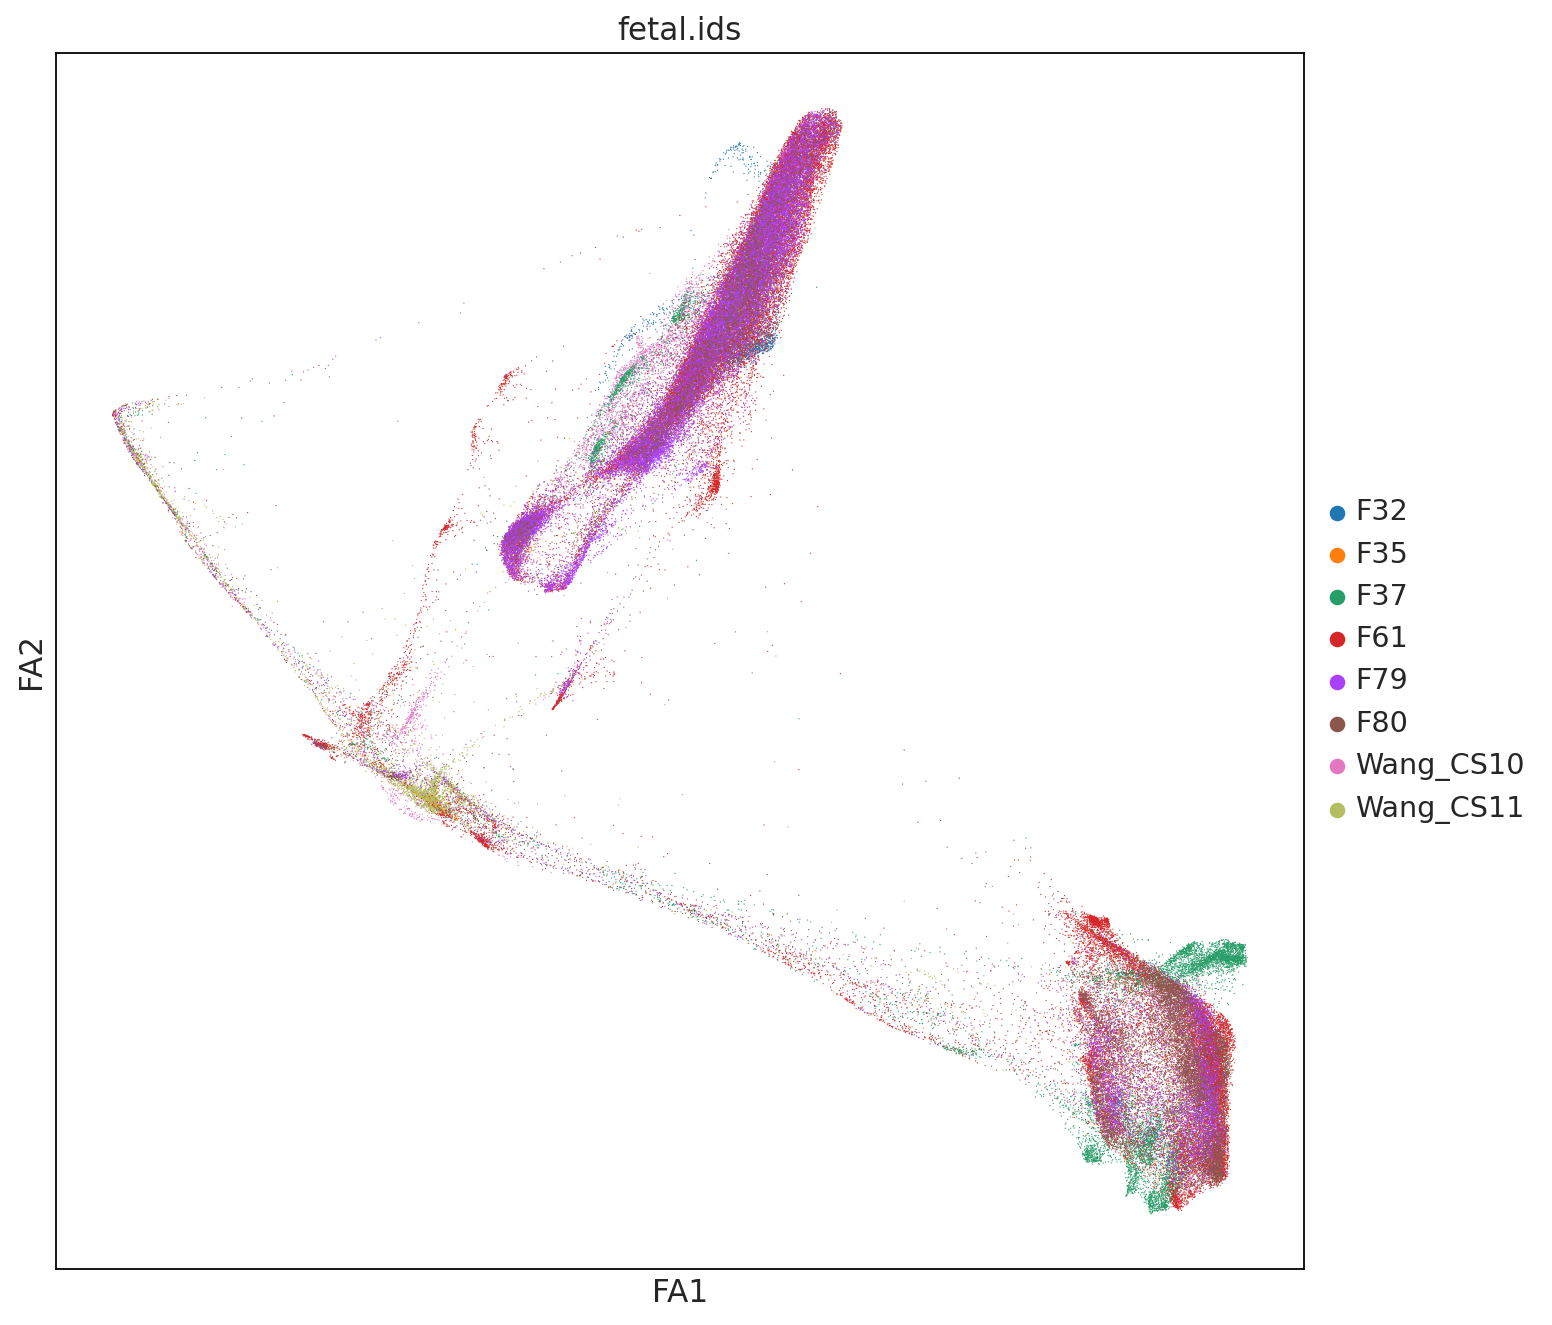

In [69]:
sc.pl.draw_graph(adata2, color = 'fetal.ids')

In [89]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].astype(str)
adata2.obs['cell.labels'] = adata.obs['cell.labels'][adata.obs.index.isin(adata2.obs.index)]
adata2 = adata2[adata2.obs.index.isin(adata.obs.index)]

Trying to set attribute `.obs` of view, copying.


In [205]:
adata2 = adata2[adata2.obs['cell.labels'].isin([
'HSPC_1',
'HSPC_2',
'CMP',
'MEMP'
'LMPP',
'Lymphoid_progenitor',
'MOP',
'ILC_precursor',
'NK',
'pDC precursor',])]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell.labels' as categorical


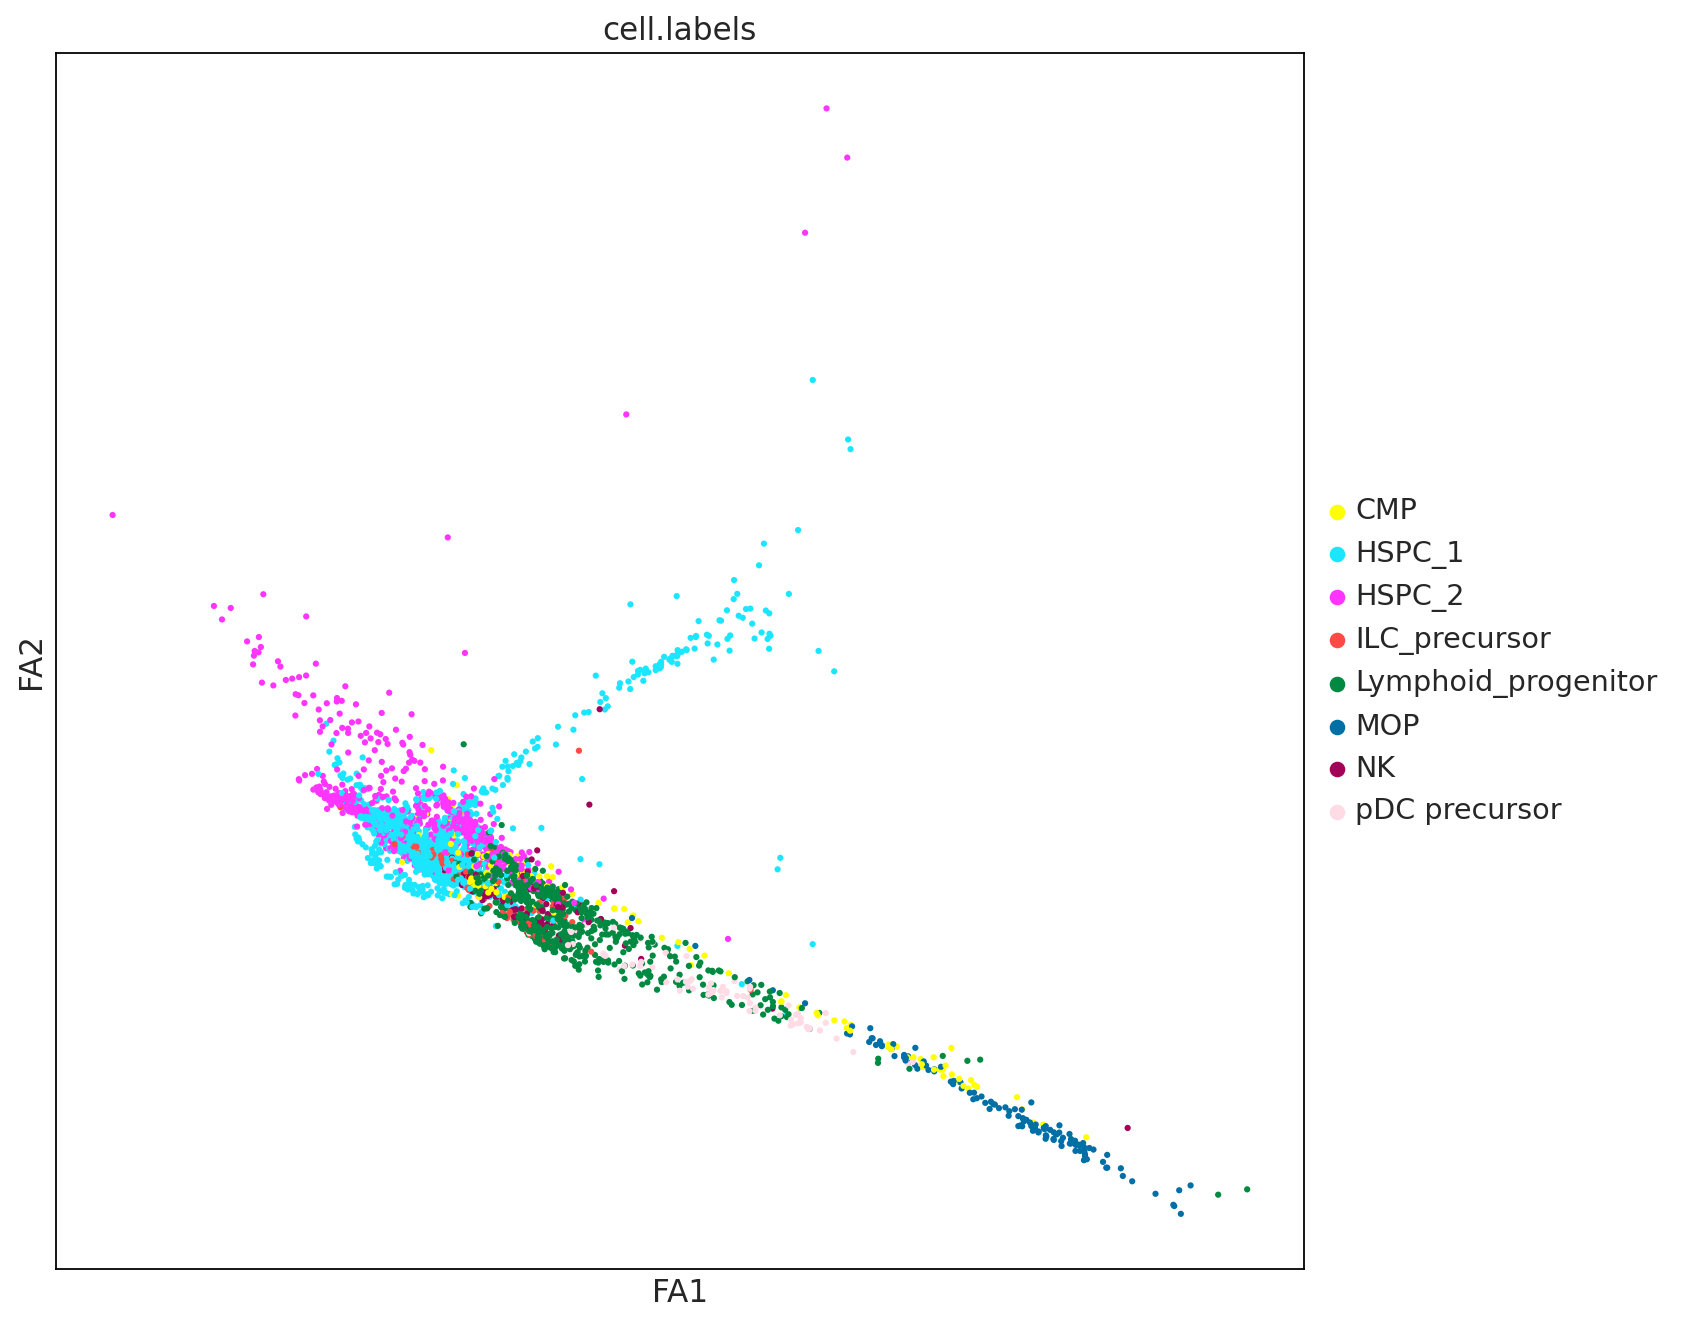

In [90]:
sc.pl.draw_graph(adata2, color = 'cell.labels')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


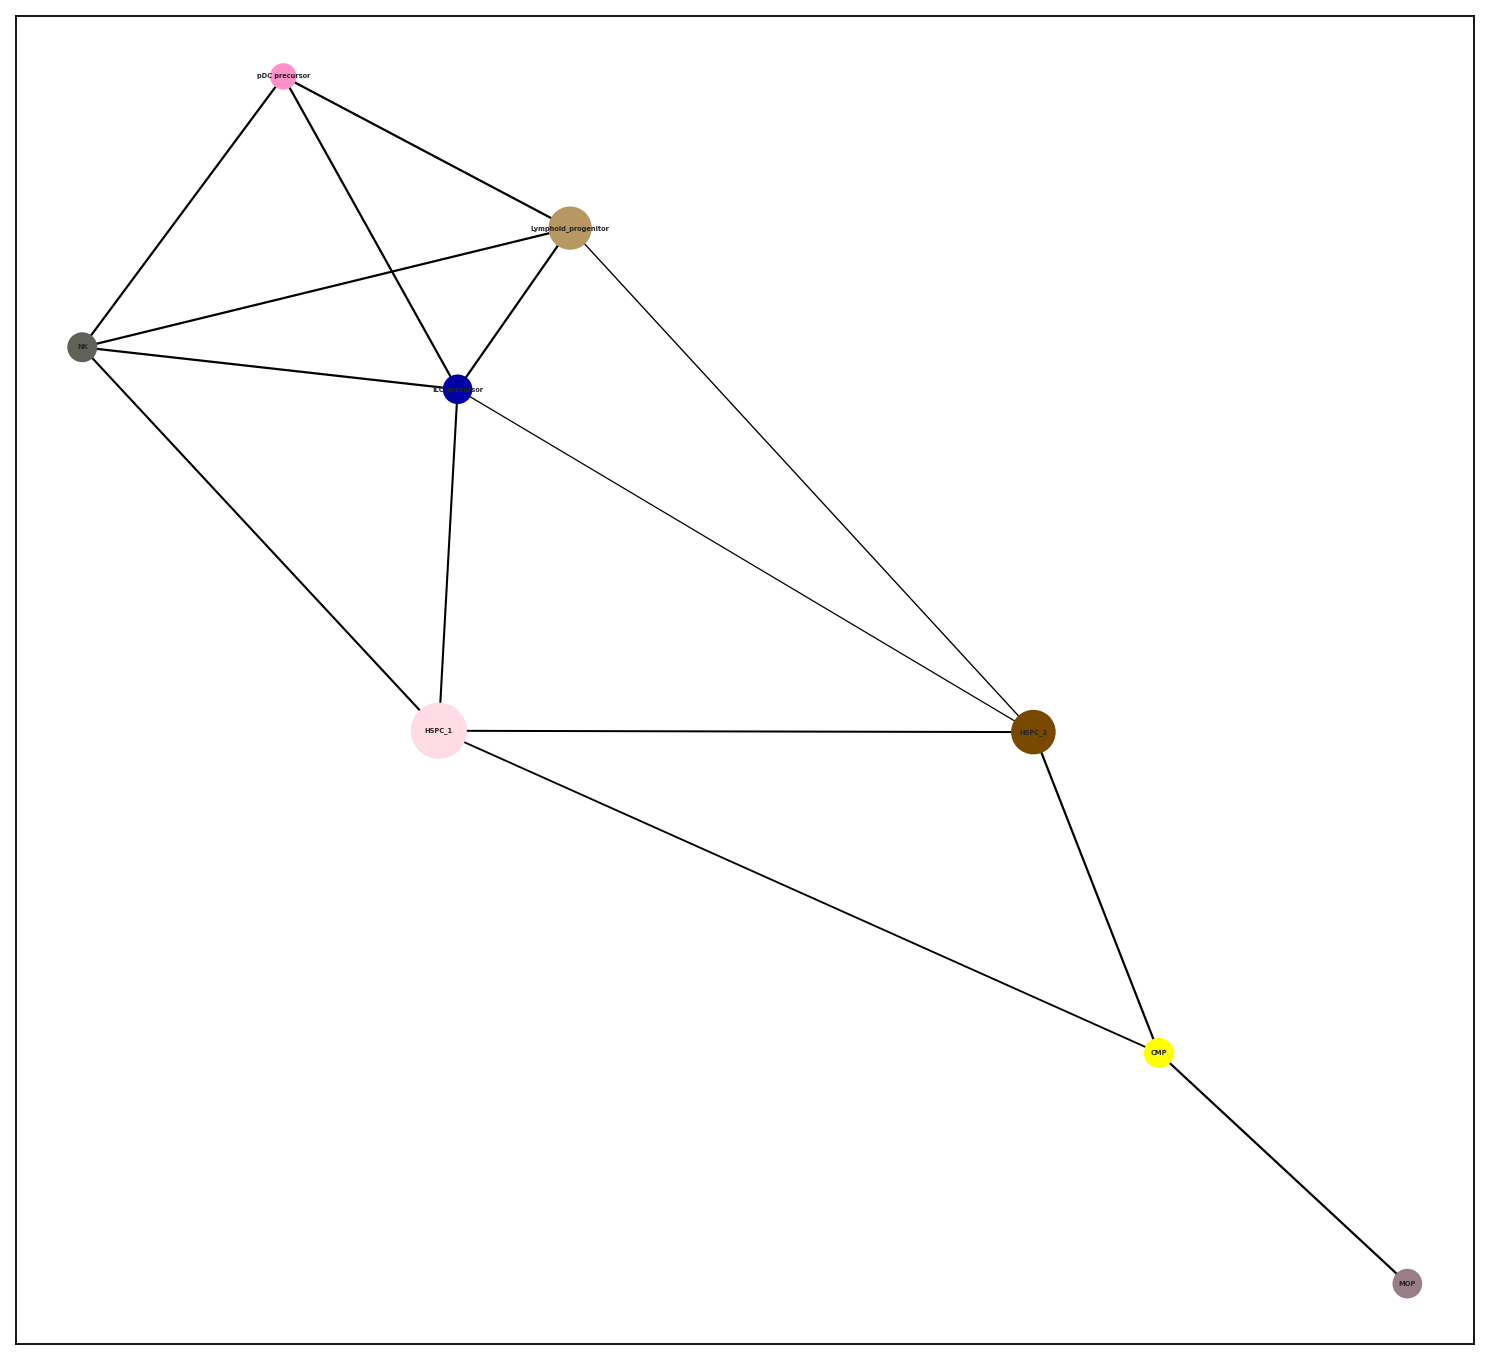

In [214]:
#sc.pp.neighbors(adata2, n_neighbors=15, n_pcs=30)
sc.tl.paga(adata2, groups='cell.labels', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)
sc.pl.paga(adata2, threshold=0.15, color = 'cell.labels' , root=0, solid_edges='connectivities',max_edge_width=1, edge_width_scale=0.5,fontsize = 3)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:30)


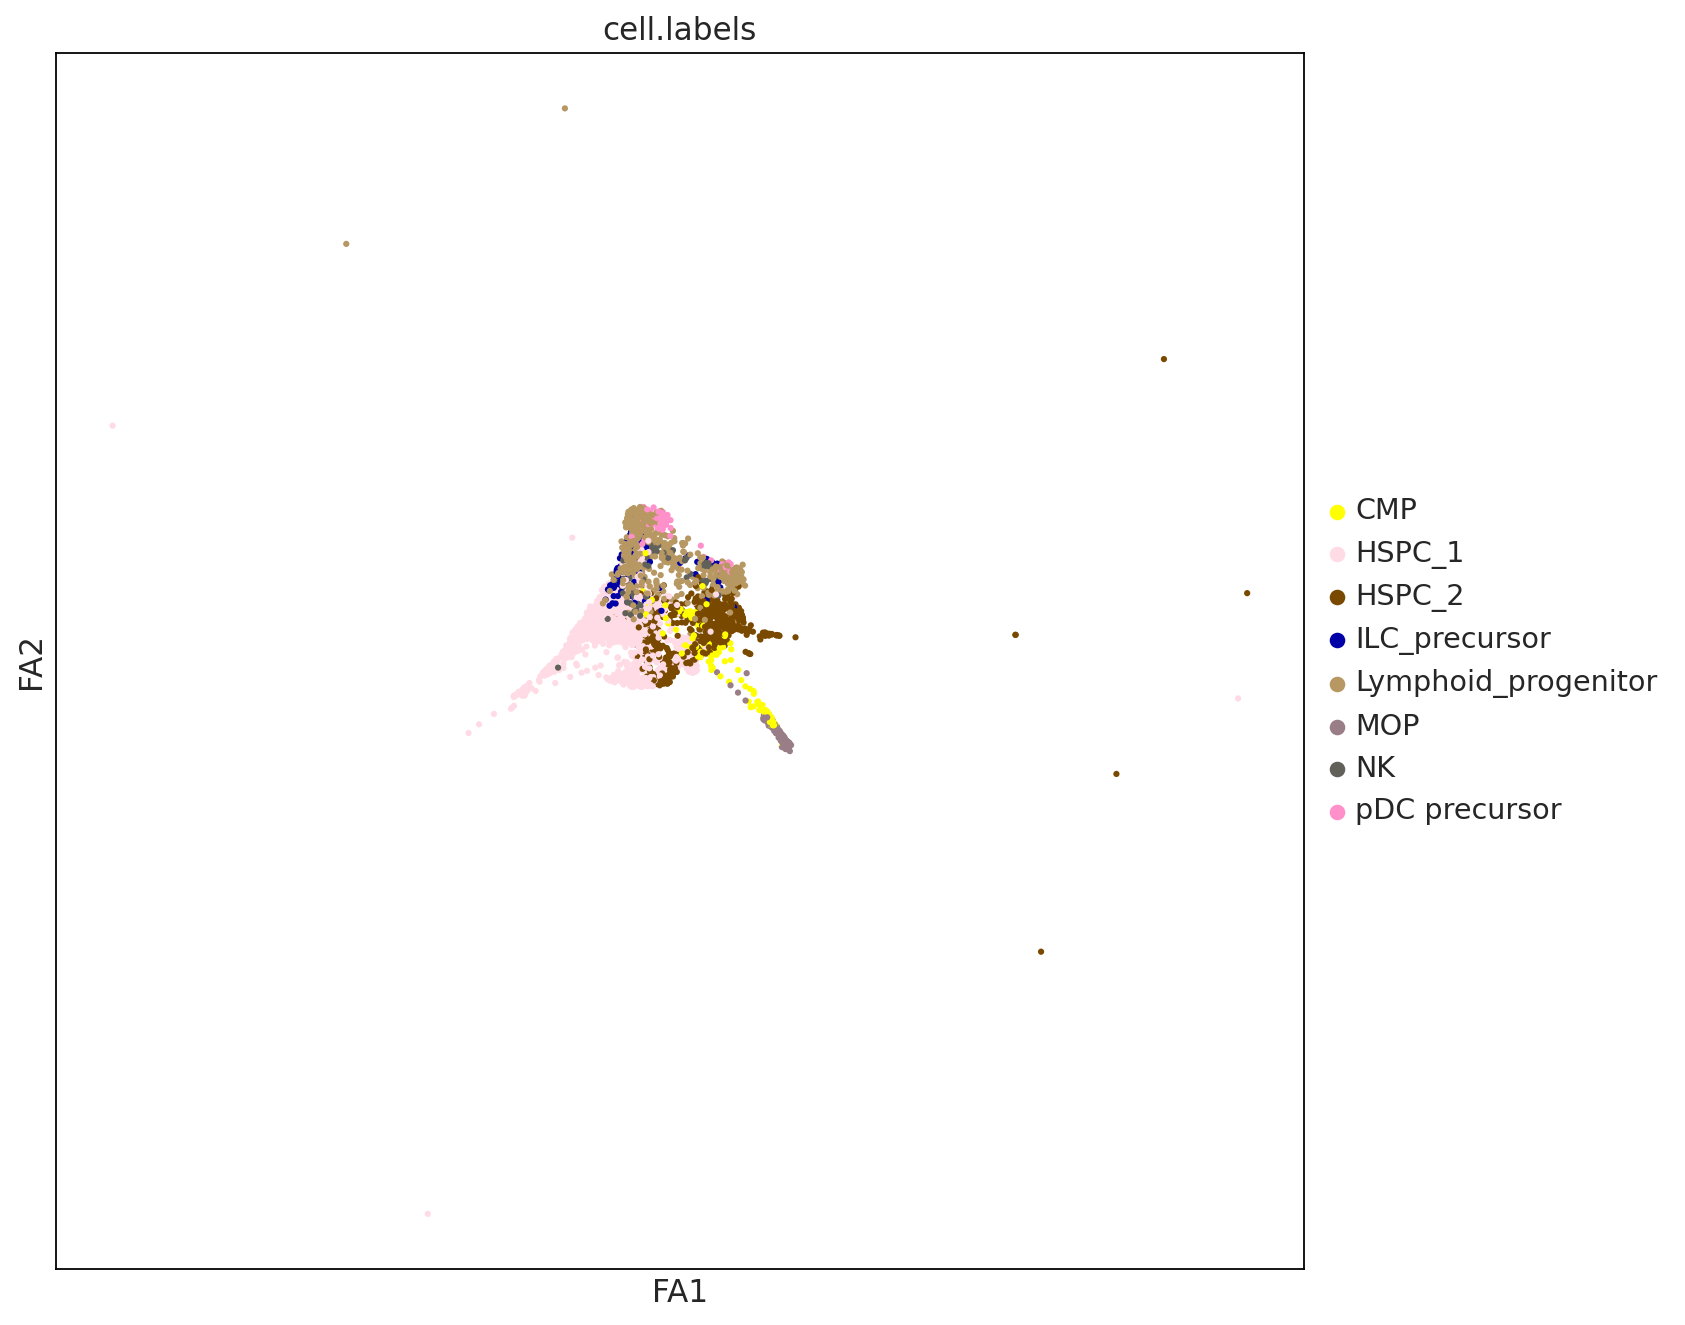

In [216]:
# sc.pl.umap(adata2,color = 'cell.labels')
sc.tl.draw_graph(adata2, layout='fa',init_pos = 'paga')
sc.pl.draw_graph(adata2, color = 'cell.labels')

# preprocess

In [217]:
run_name = 'YS_lymphoid_progen_traj_030422'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V8_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20220328_with_obsp.h5ad'

In [218]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'V6_old_indexes'],
      dtype='object')

In [219]:
adata = adata[adata.obs['cell.labels'].isin([
'HSPC_1',
'HSPC_2',
'CMP',
'MEMP'
'LMPP',
'Lymphoid_progenitor',
'MOP',
'ILC_precursor',
'NK',
'pDC precursor',])]

In [220]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].astype('category')
adata.obs['cell.labels'].reorder_categories=['HSPC_1', 'HSPC_2', 'CMP', 'MEMPLMPP', 'Lymphoid_progenitor', 'MOP', 'ILC_precursor', 'NK', 'pDC precursor']
list(adata.obs['cell.labels'].unique())

Trying to set attribute `.obs` of view, copying.


['HSPC_1',
 'Lymphoid_progenitor',
 'HSPC_2',
 'MOP',
 'CMP',
 'ILC_precursor',
 'NK',
 'pDC precursor']

In [221]:
# Only consider intersecting genes for normalisation etc
remove_genes = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/data_integration_070721/keep_intersecting_genes.csv',index_col=0)
keep_genes = list(remove_genes['0'])
adata = adata[:, adata.var.index.isin(keep_genes)]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [222]:
adata.obs

cell.labels stage  \
Wang_et_al_AAACCTGCACTTAAGC_1                                    HSPC_1  CS10   
Wang_et_al_AAAGATGGTTGGACCC_1                                    HSPC_1  CS10   
Wang_et_al_AAAGTAGAGTGGTCCC_1                                    HSPC_1  CS10   
Wang_et_al_AAATGCCTCTGACCTC_1                       Lymphoid_progenitor  CS10   
Wang_et_al_AACACGTCATCTATGG_1                       Lymphoid_progenitor  CS10   
...                                                                 ...   ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT                   CMP  CS15   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA                HSPC_2  CS15   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA                   CMP  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...                  MOP  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...                  CMP  CS15   

                                                             lanes   sex  \
Wang_et_al_AAACCTGCACTTAAGC_1                            Wang_CS10  Male   
Wang_et_al_AAAGATGGTTGGACCC_1                            Wang_CS10  Male   
Wang_et_al_AAAGTAGAGTGGTCCC_1                            Wang_CS10  Male   
Wang_et_al_AAATGCCTCTGACCTC_1                            Wang_CS10  Male   
Wang_et_al_AACACGTCATCTATGG_1                            Wang_CS10  Male   
...                                                            ...   ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT   FCAImmP8096694  Male   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA   FCAImmP8096694  Male   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA   FCAImmP8096695  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  FCAImmP8096696  Male   

                                                   sort.ids  fetal.ids  \
Wang_et_al_AAACCTGCACTTAAGC_1                         Total  Wang_CS10   
Wang_et_al_AAAGATGGTTGGACCC_1                         Total  Wang_CS10   
Wang_et_al_AAAGTAGAGTGGTCCC_1                         Total  Wang_CS10   
Wang_et_al_AAATGCCTCTGACCTC_1                         Total  Wang_CS10   
Wang_et_al_AACACGTCATCTATGG_1                         Total  Wang_CS10   
...                                                     ...        ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT     CD45N        F80   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA     CD45N        F80   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA     CD45N        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  CD45NAF        F80   

                                                   component  \
Wang_et_al_AAACCTGCACTTAAGC_1                       Membrane   
Wang_et_al_AAAGATGGTTGGACCC_1                       Membrane   
Wang_et_al_AAAGTAGAGTGGTCCC_1                       Membrane   
Wang_et_al_AAATGCCTCTGACCTC_1                       Membrane   
Wang_et_al_AACACGTCATCTATGG_1                       Membrane   
...                                                      ...   
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT   Membrane   
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA   Membrane   
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA   Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCT...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAAC...  Membrane   

                                                   broad_cell.labels  \
Wang_et_al_AAACCTGCACTTAAGC_1                            Progenitors   
Wang_et_al_AAAGATGGTTGGACCC_1                            Progenitors   
Wang_et_al_AAAGTAGAGTGGTCCC_1                            Progenitors   
Wang_et_al_AAATGCCTCTGACCTC_1                            Progenitors   
Wang_et_al_AACACGTCATCTATGG_1                            Progenitors   
...                                                              ...   
F80_Yolksac_

In [223]:
adata_orig = adata2[:]

In [224]:
adata_orig

View of AnnData object with n_obs × n_vars = 3818 × 16970
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'V5_old_indexes'
    var: 'n_cells', 'mt', 'total_counts', 'highly_variable', 'intersect', 'means', 'dispersions', 'dispersions_norm'
    uns: 'broad_cell.labels_colors', 'cell.labels_colors', 'draw_graph', 'hvg', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'paga', 'cell.labels_sizes'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_back', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [225]:
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ['fetal.ids'] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2
sc.pp.pca(adata, n_comps=70, use_highly_variable=True, svd_solver='arpack')
theta = 4
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = batch
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta = theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
#     sc.tl.umap(adata_hm)
    adata = adata_hm[:]
    del adata_hm

computing PCA
    on highly variable genes
    with n_comps=70
    finished (0:00:10)
Commencing harmony


2022-04-04 15:35:06,087 - harmonypy - INFO - Iteration 1 of 10
2022-04-04 15:35:12,203 - harmonypy - INFO - Iteration 2 of 10
2022-04-04 15:35:18,090 - harmonypy - INFO - Iteration 3 of 10
2022-04-04 15:35:23,394 - harmonypy - INFO - Iteration 4 of 10
2022-04-04 15:35:30,490 - harmonypy - INFO - Iteration 5 of 10
2022-04-04 15:35:36,595 - harmonypy - INFO - Iteration 6 of 10
2022-04-04 15:35:41,194 - harmonypy - INFO - Iteration 7 of 10
2022-04-04 15:35:45,796 - harmonypy - INFO - Iteration 8 of 10
2022-04-04 15:35:49,587 - harmonypy - INFO - Iteration 9 of 10
2022-04-04 15:35:53,285 - harmonypy - INFO - Iteration 10 of 10
2022-04-04 15:35:58,703 - harmonypy - INFO - Stopped before convergence


In [226]:
sc.pp.neighbors(adata, n_neighbors=18, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [237]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=25)
sc.tl.paga(adata, groups='cell.labels', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [238]:
sc.tl.paga(adata, groups='cell.labels', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


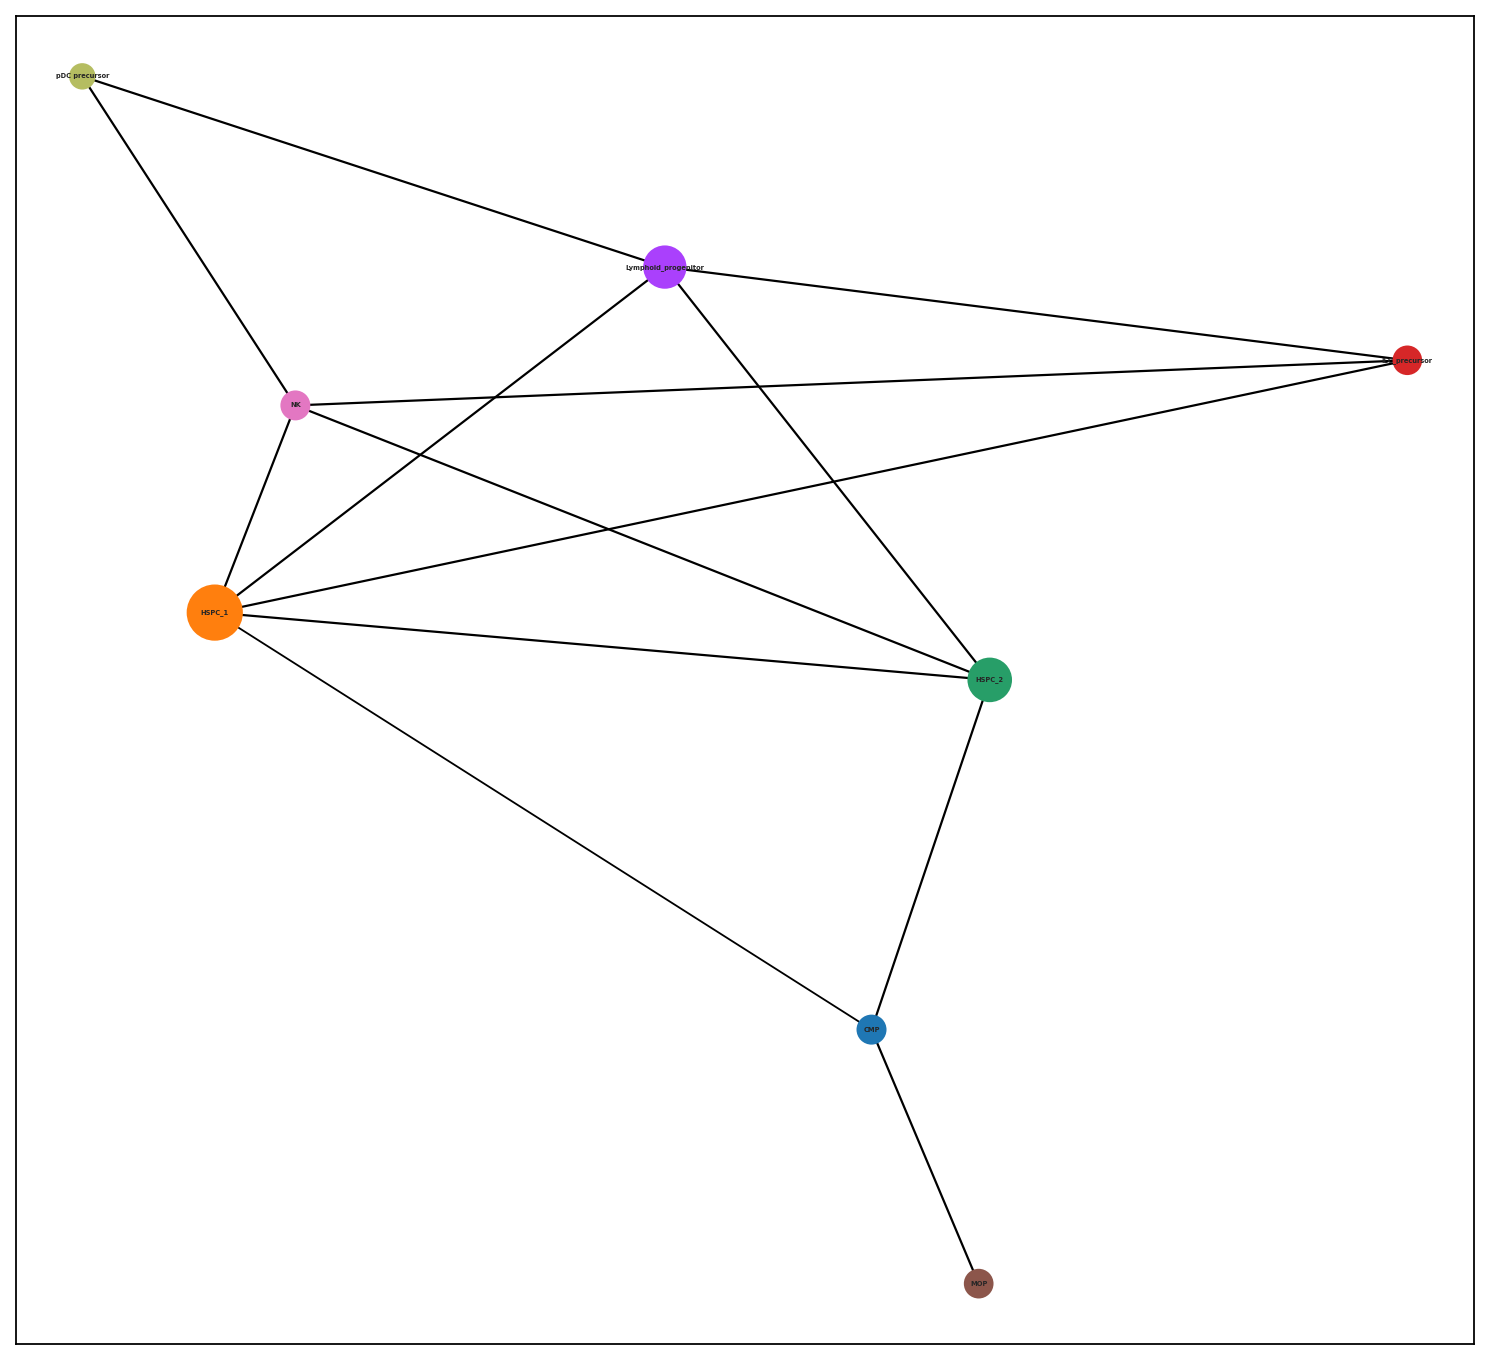

In [241]:
sc.pl.paga(adata, threshold=0.2, color = 'cell.labels' , root=0, solid_edges='connectivities',max_edge_width=1, edge_width_scale=0.5,fontsize = 3)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:23)


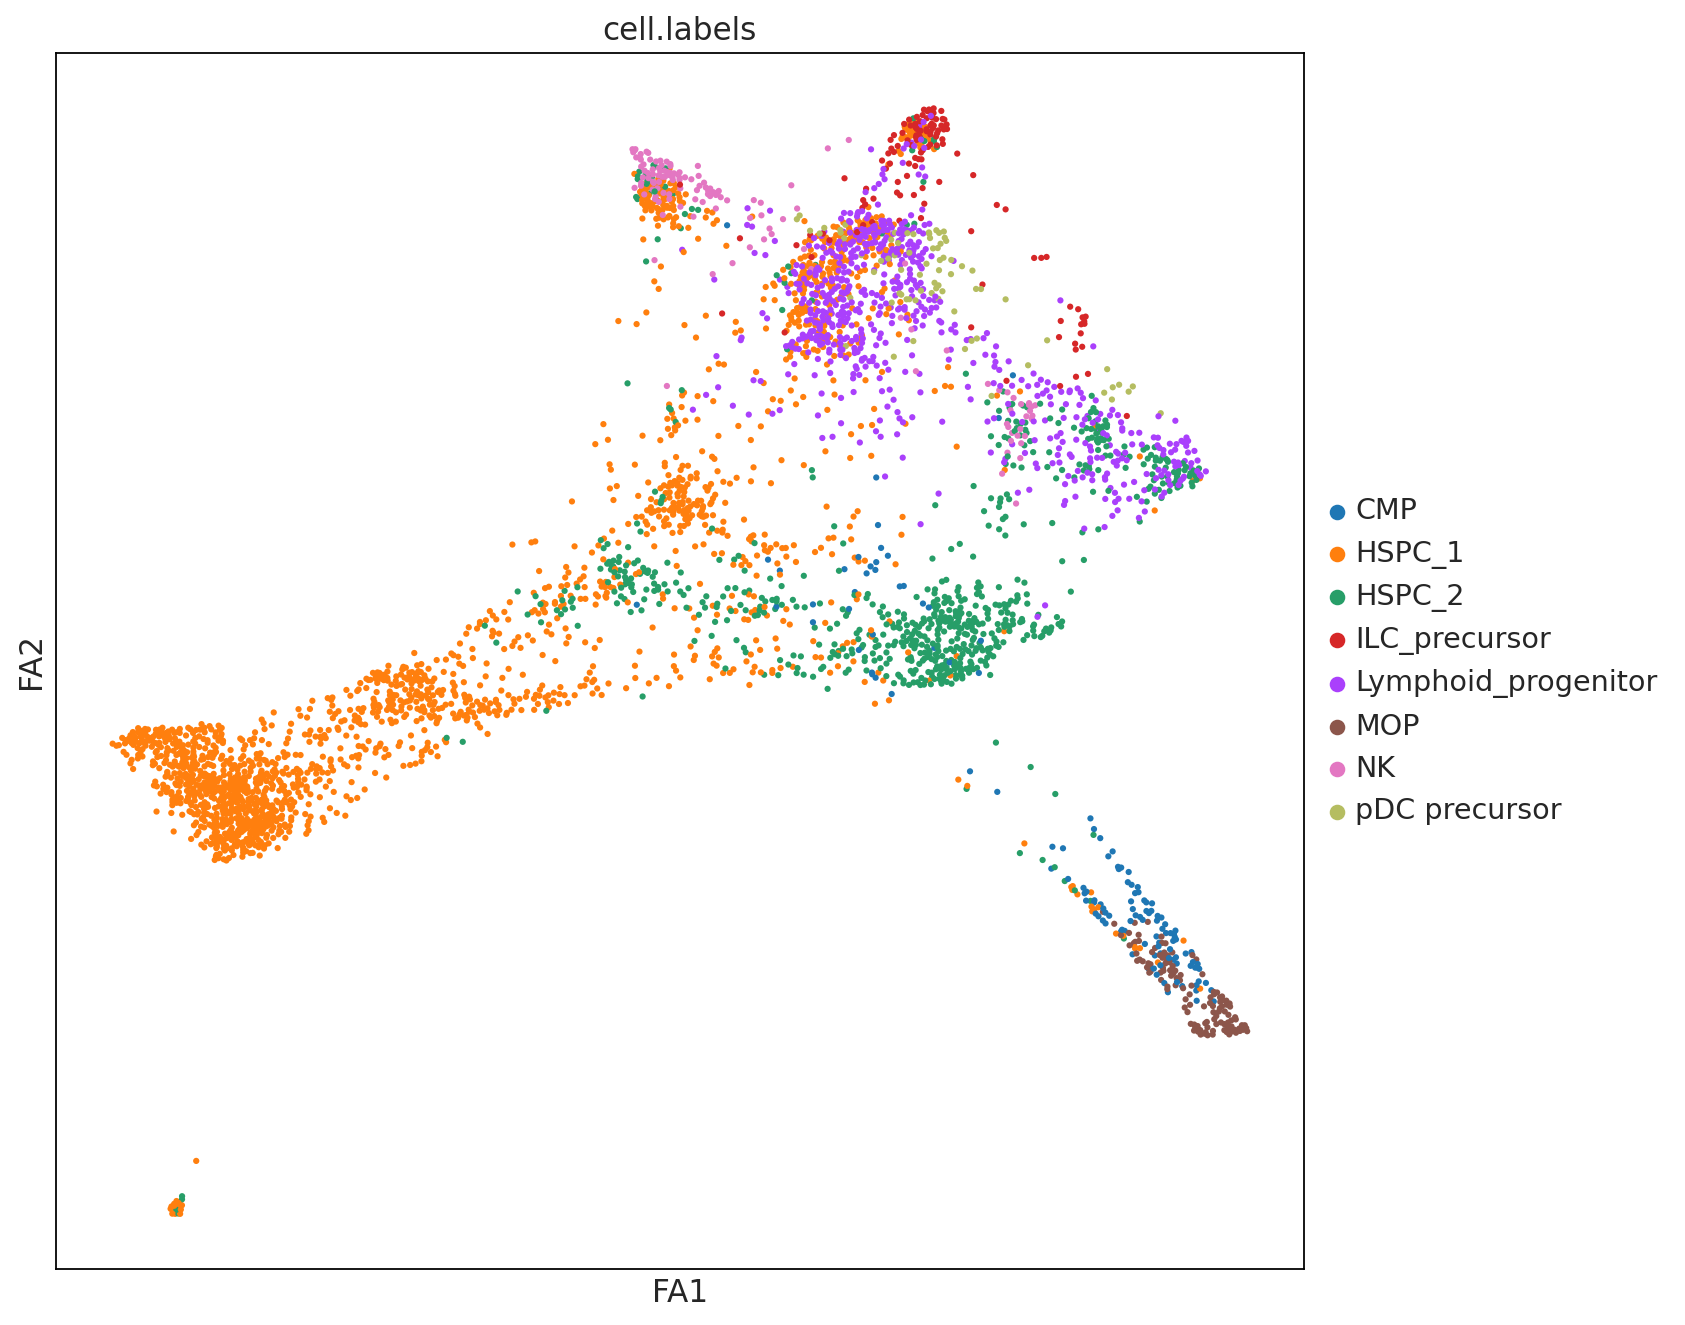

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


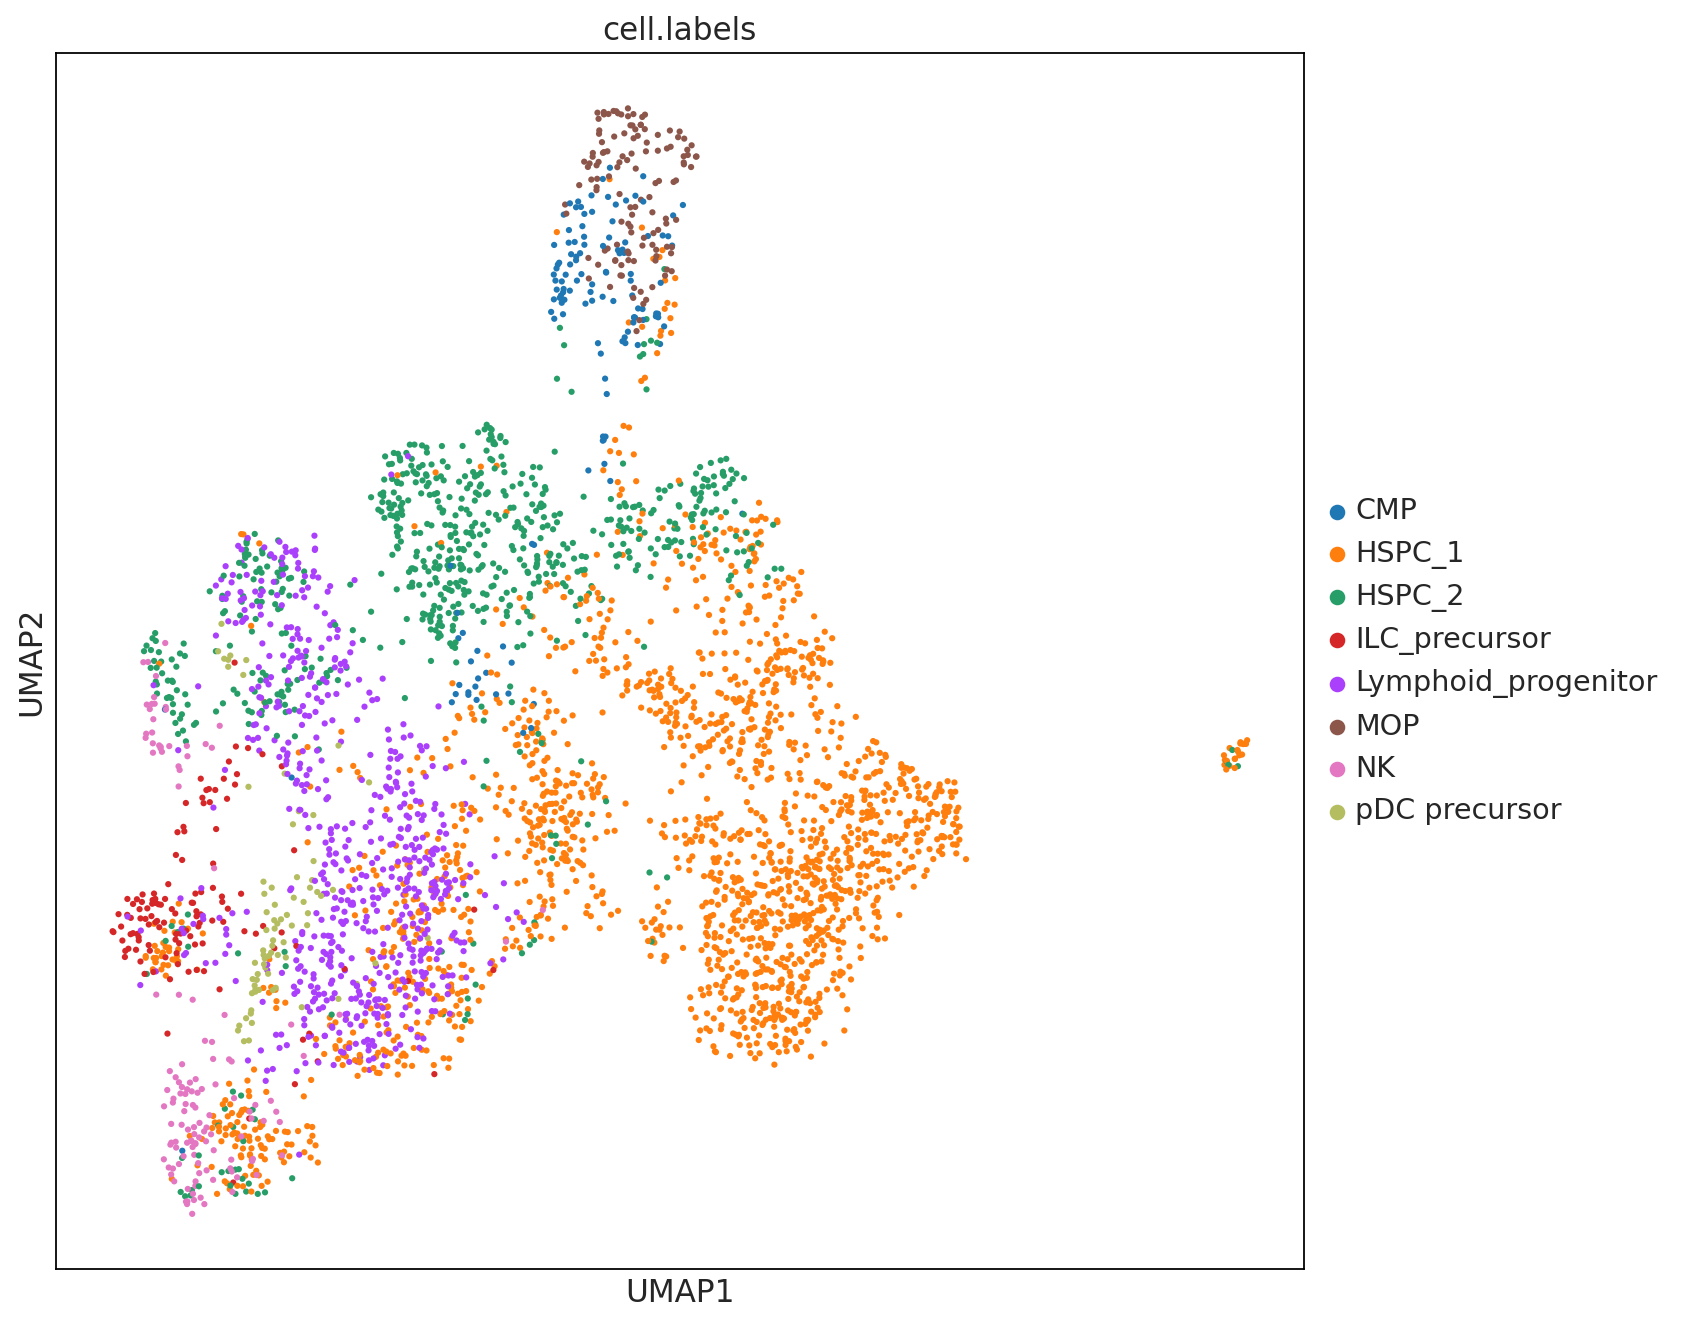

In [242]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color = 'cell.labels')
sc.tl.umap(adata)
sc.pl.umap(adata,color = 'cell.labels')

# cellxgene update

In [244]:
obj_path = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/lymphoid_traj_fig2_fdg/ys_lymphoid_traj.h5ad'
port = 5010
! source activate workhorse ; cellxgene launch $obj_path --port $port --host 0.0.0.0

There's a new version of cellxgene available (1.0.1)!
To upgrade, run the following: pip install --upgrade cellxgene

[cellxgene] Starting the CLI...
[cellxgene] Loading data from ys_lymphoid_traj.h5ad, this may take a while...
[cellxgene] Warning: Anndata data matrix is sparse, but not a CSC (columnar) matrix.  Performance may be improved by using CSC. 
[cellxgene] Launching! Please go to http://0.0.0.0:5010 in your browser.
[cellxgene] Type CTRL-C at any time to exit.
^C


In [ ]:
#update cellxgene annots
import pandas as pd
import scanpy as sc

new_annotations = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/lymphoid_traj_fig2_fdg/IG_bm-cell-labels-POXL2XN4.csv',
                         comment='#',
                         dtype='category',
                         index_col=0)
adata.obs = adata.obs.join(new_annotations)

In [250]:
adata = adata[~adata.obs['assign'].isin(['remove'])]
adata.obs['cell.labels'] = adata.obs['assign'][:]

Trying to set attribute `.obs` of view, copying.


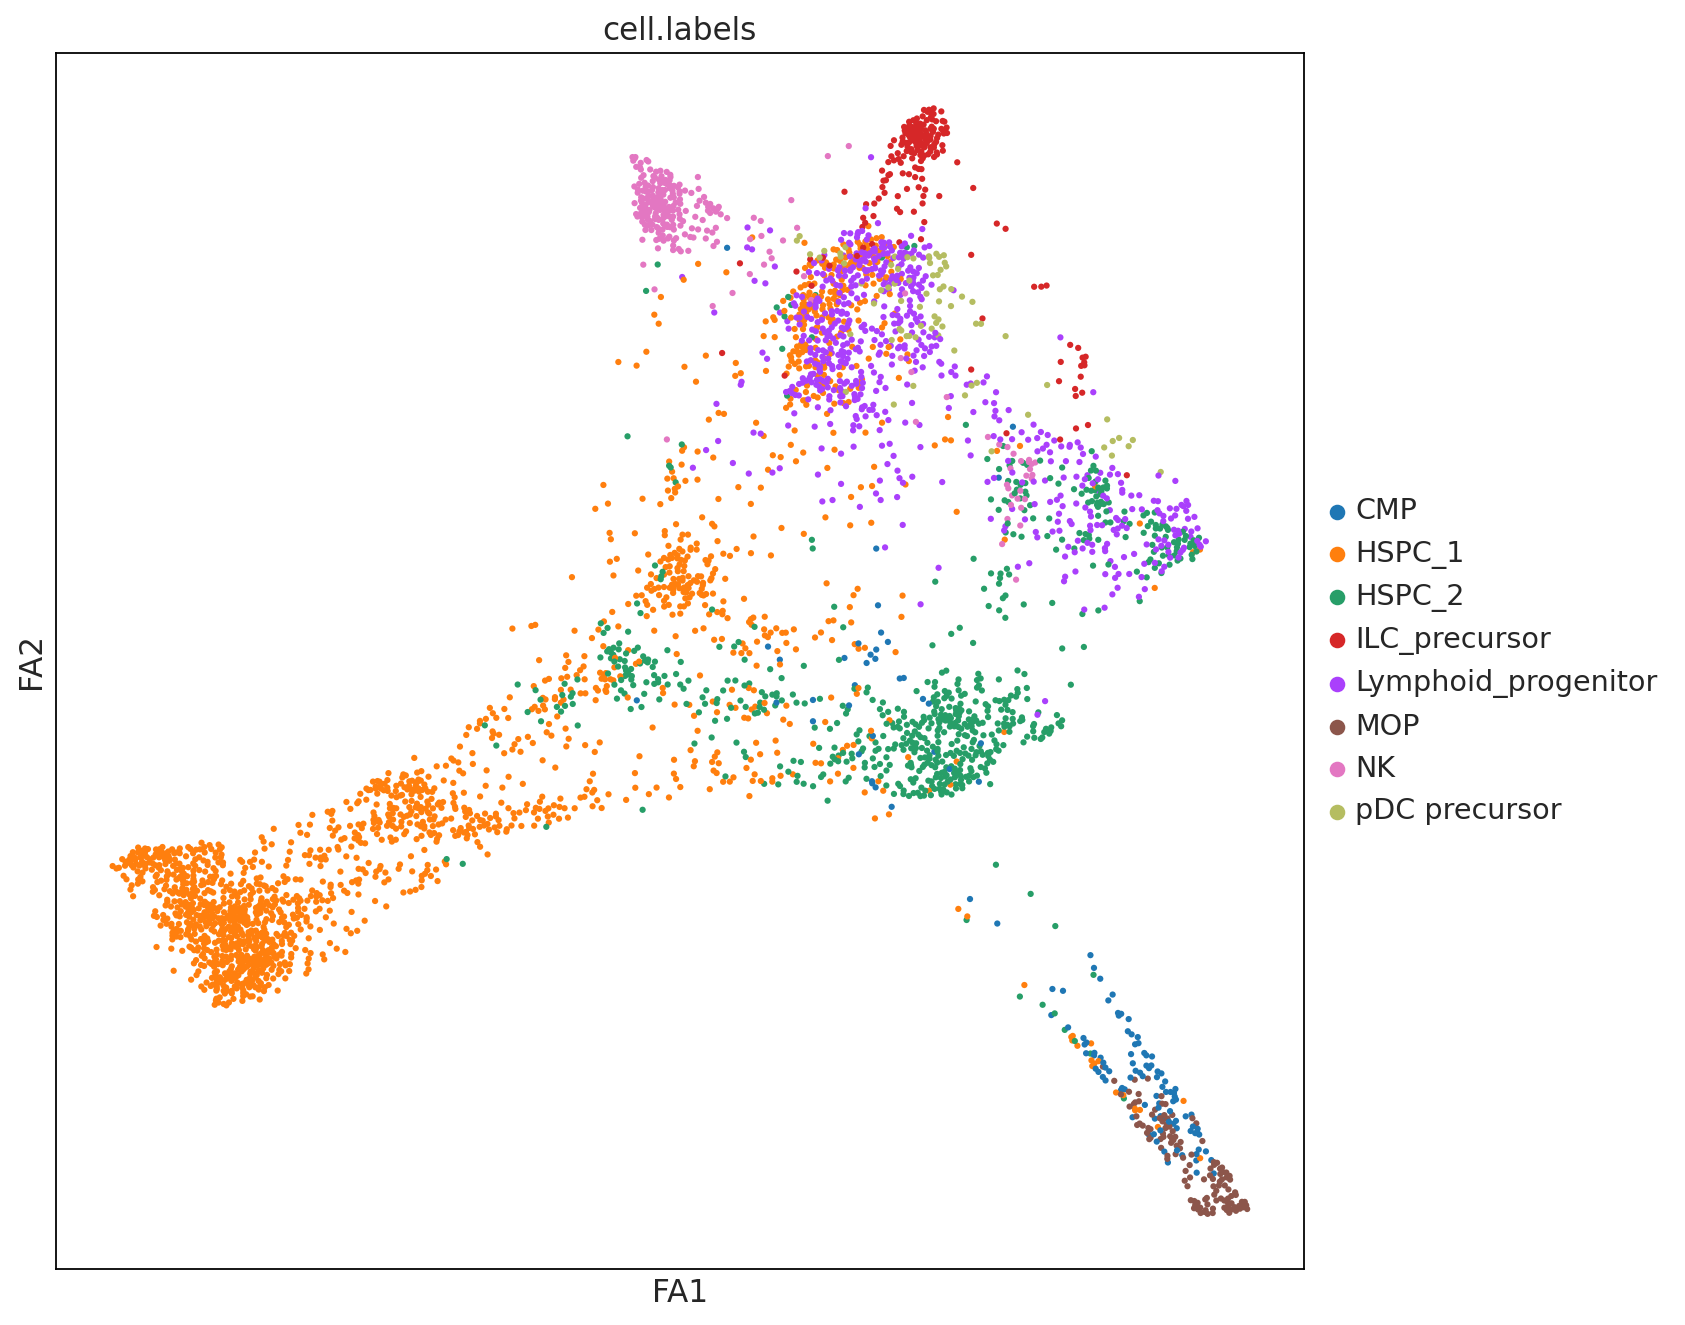

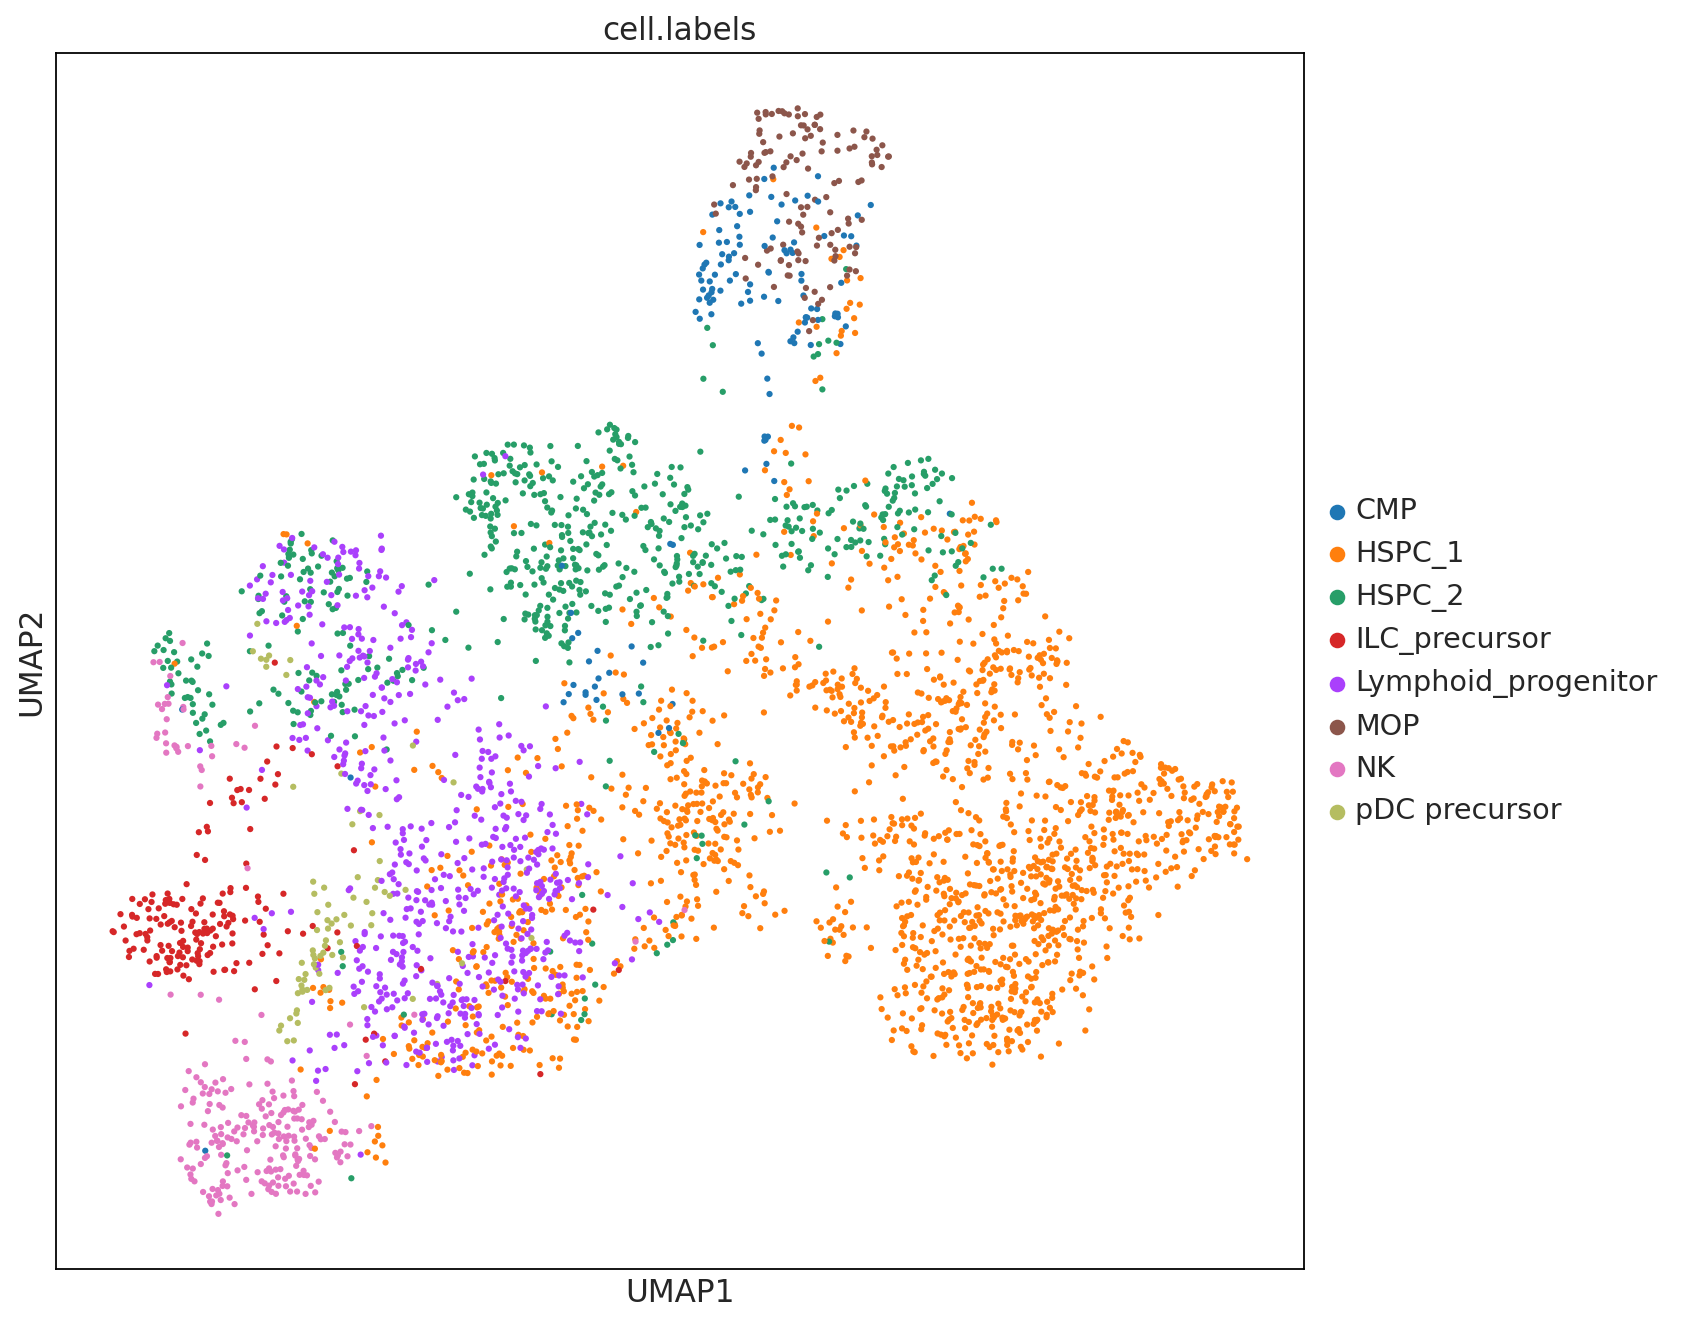

In [252]:
sc.pl.draw_graph(adata, color = 'cell.labels',save = '040422_YS_lymphoid_traj')
sc.pl.umap(adata,color = 'cell.labels')

In [253]:
adata.write('./040422_ys_lymphoid_traj.h5ad')

In [197]:
sc.tl.draw_graph(adata, obsp = 'connectivities')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:21)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


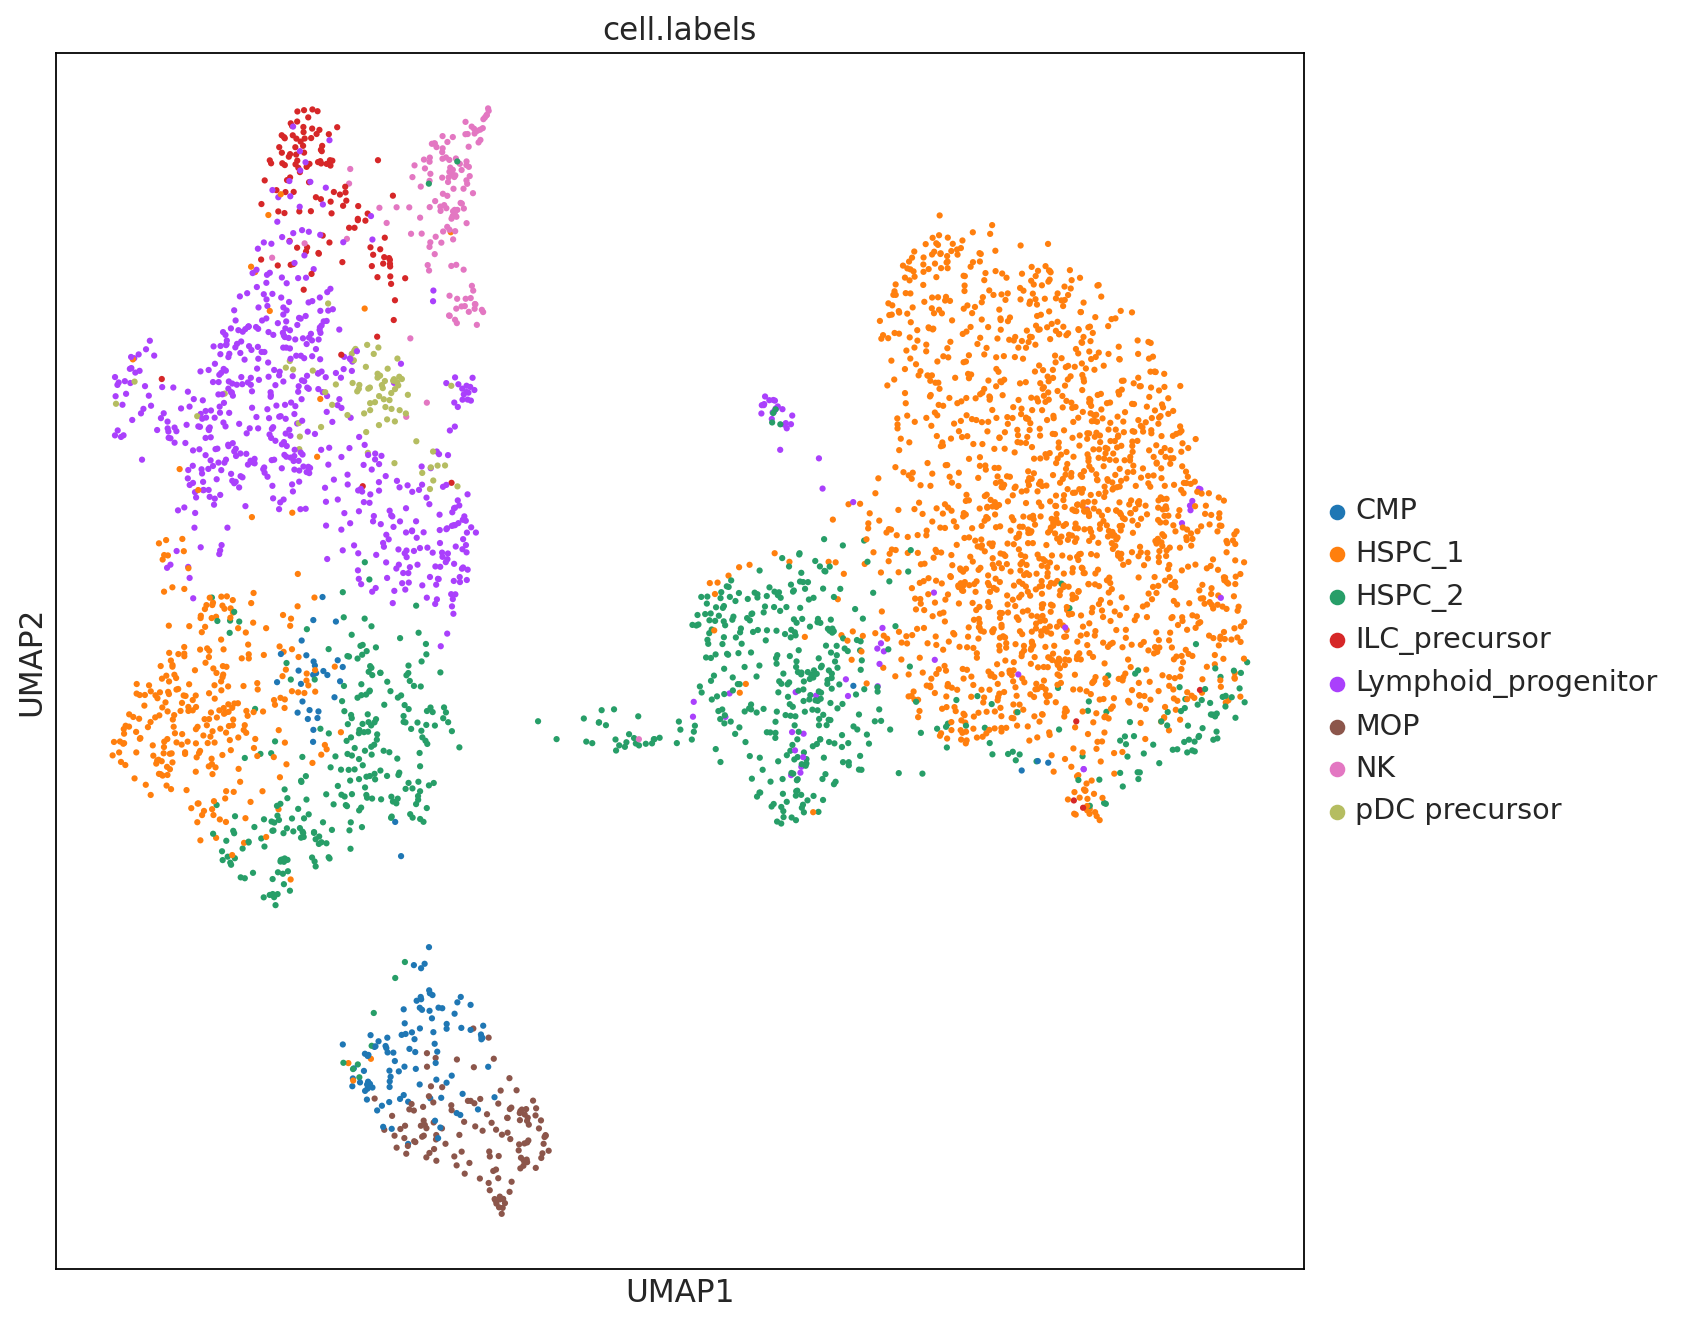

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:20)


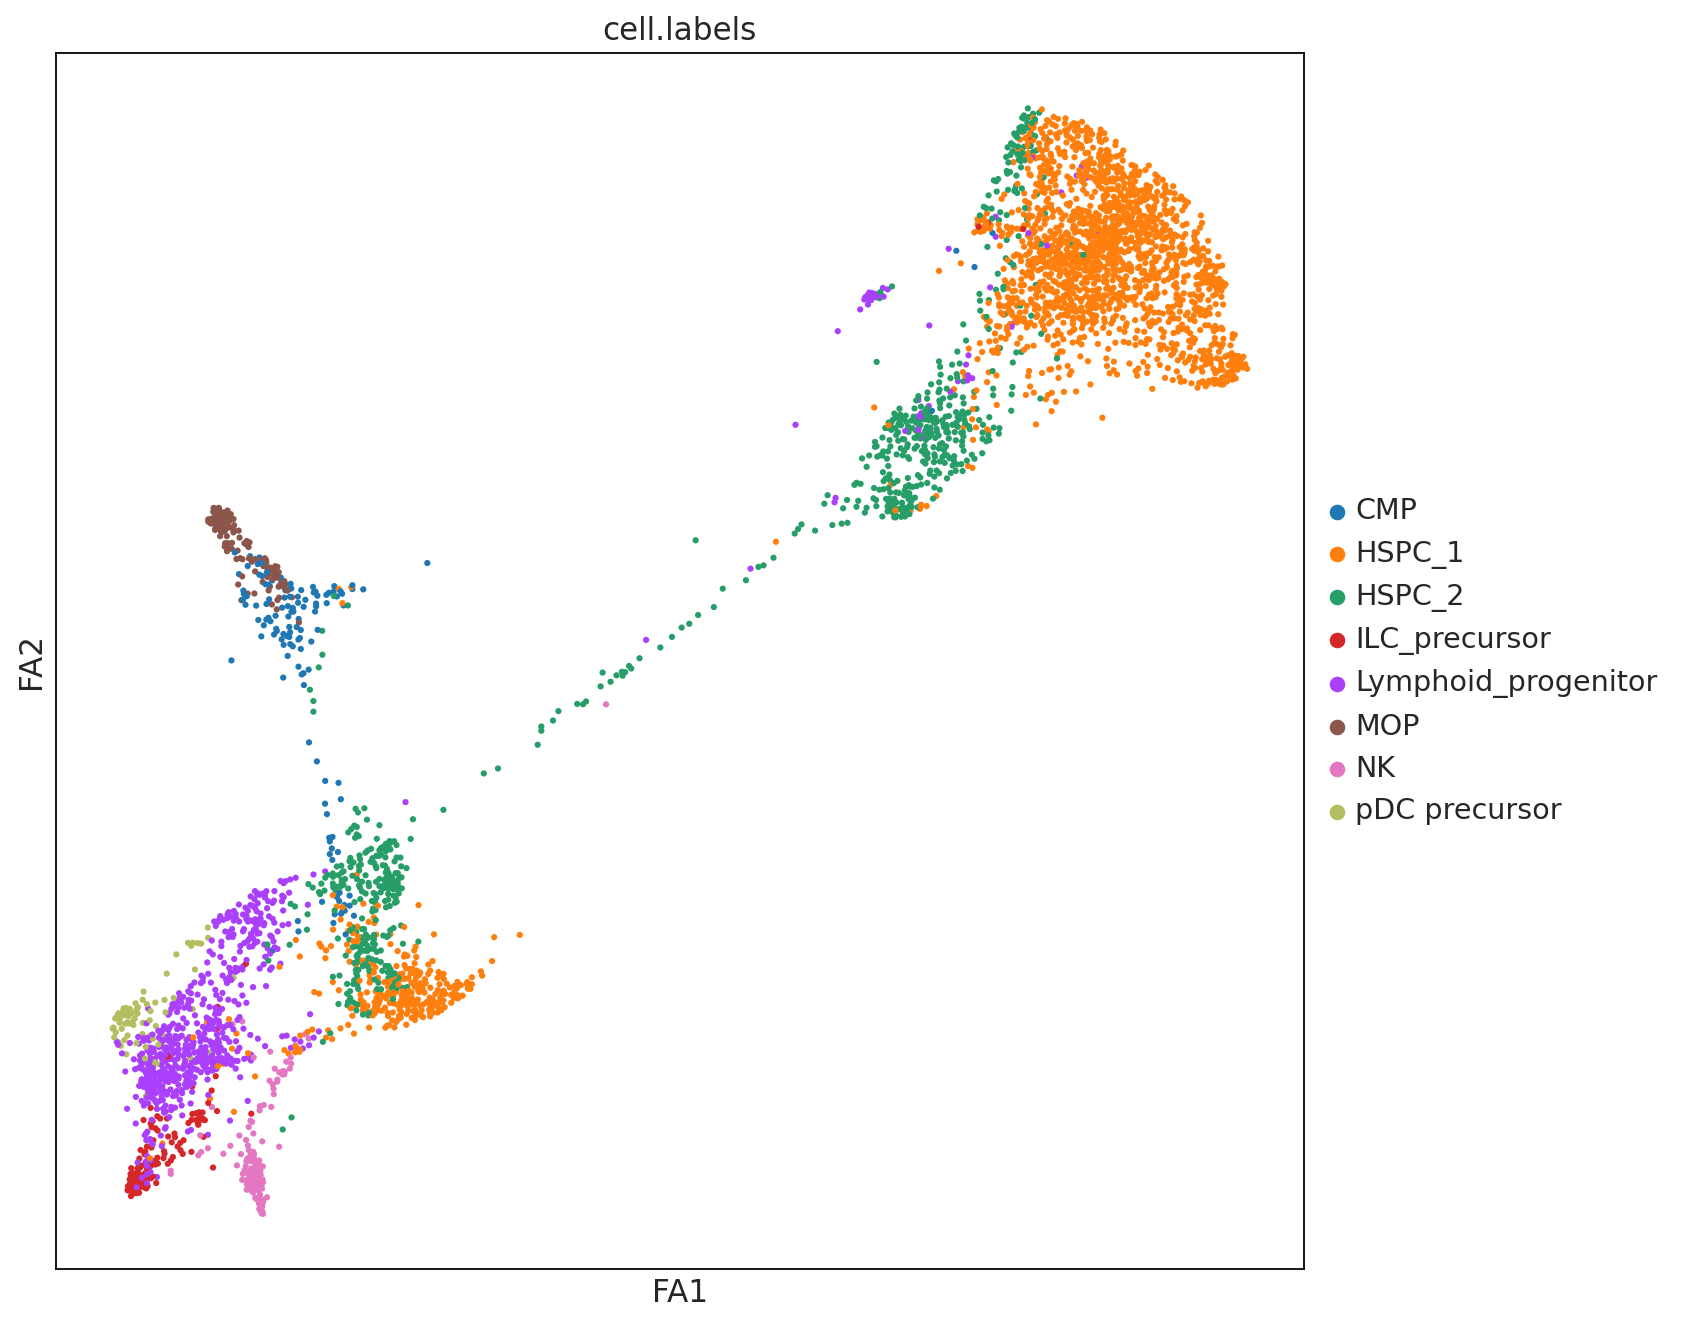

In [153]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

adata = adata[adata.obs['cell.labels'].isin([
'HSPC_1',
'HSPC_2',
'CMP',
'MEMP'
'LMPP',
'Lymphoid_progenitor',
'MOP',
'ILC_precursor',
'NK',
'pDC precursor',])]

sc.tl.umap(adata)
sc.pl.umap(adata,color = 'cell.labels')
sc.tl.draw_graph(adata, layout='fa')
sc.pl.draw_graph(adata, color = 'cell.labels')

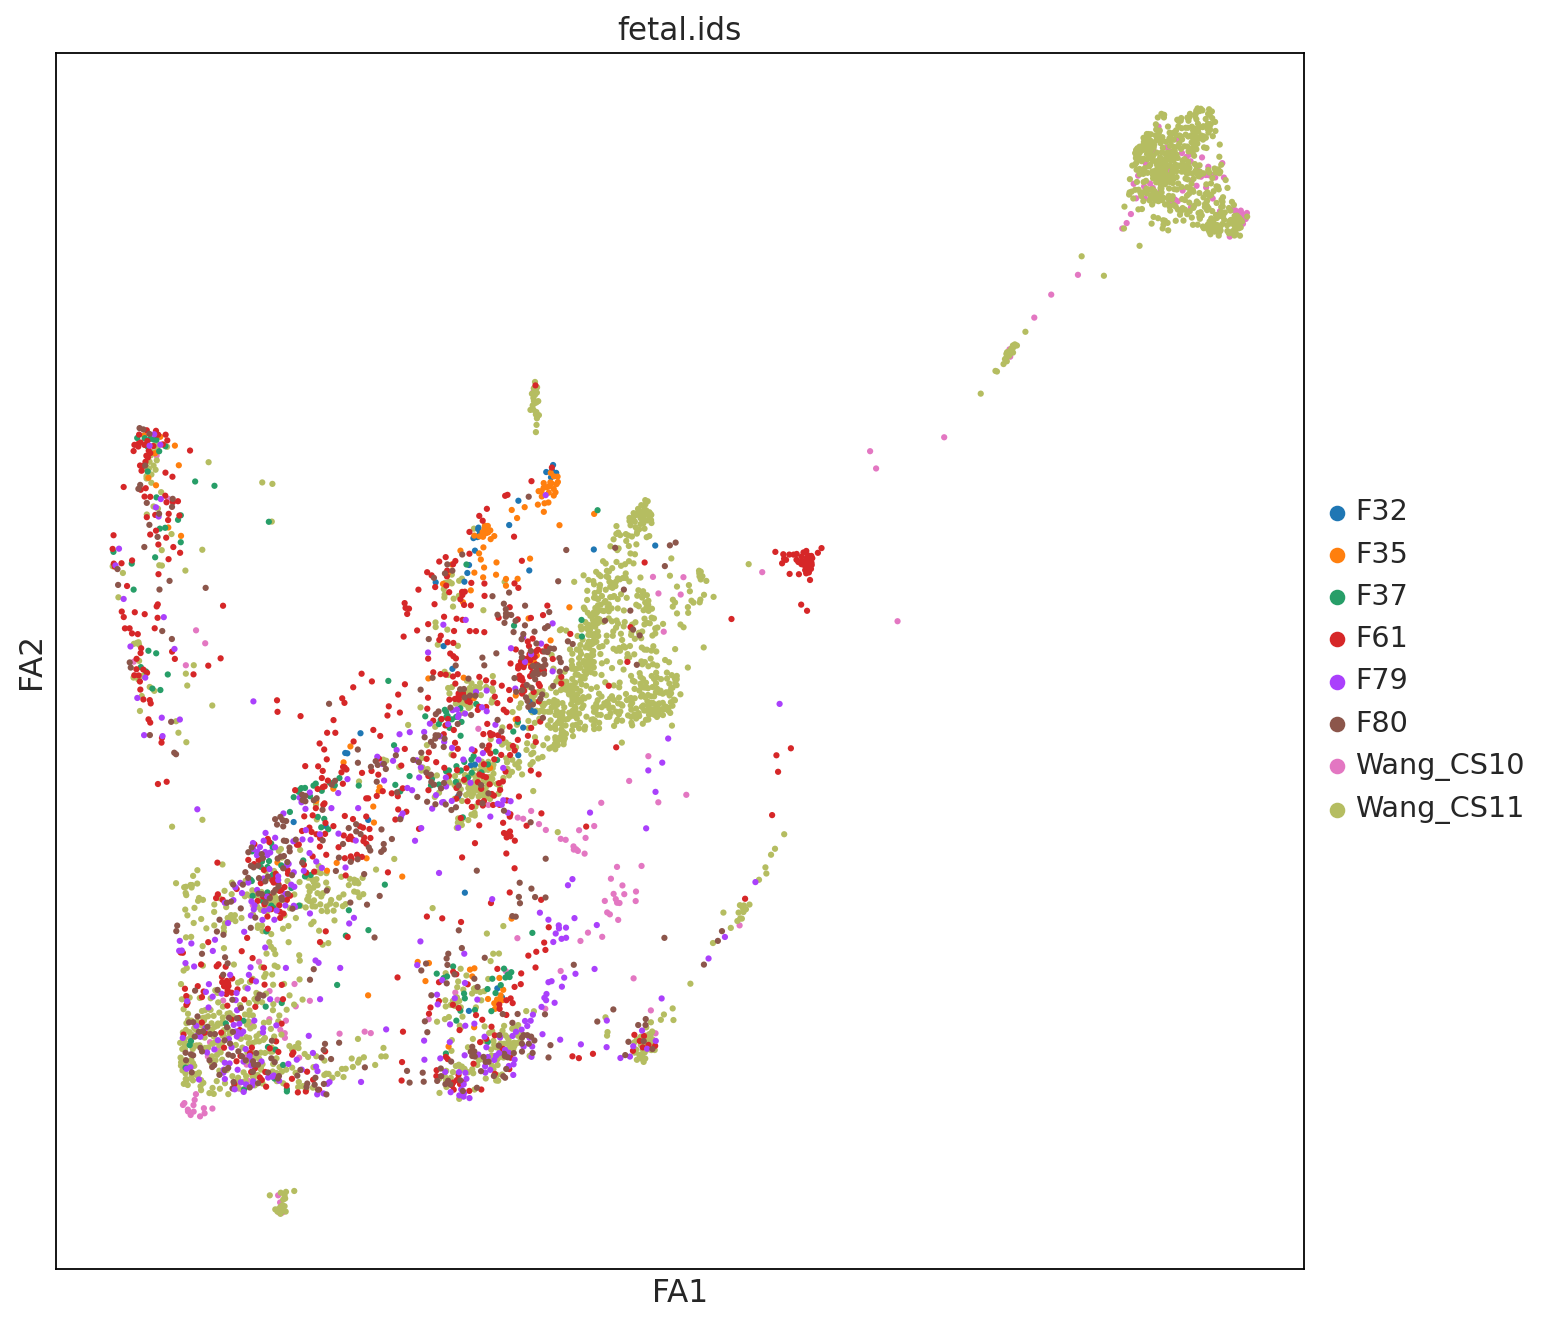

In [151]:
sc.pl.draw_graph(adata, color = 'fetal.ids')

In [142]:
adata.write(save_loc+run_name+'.h5ad')

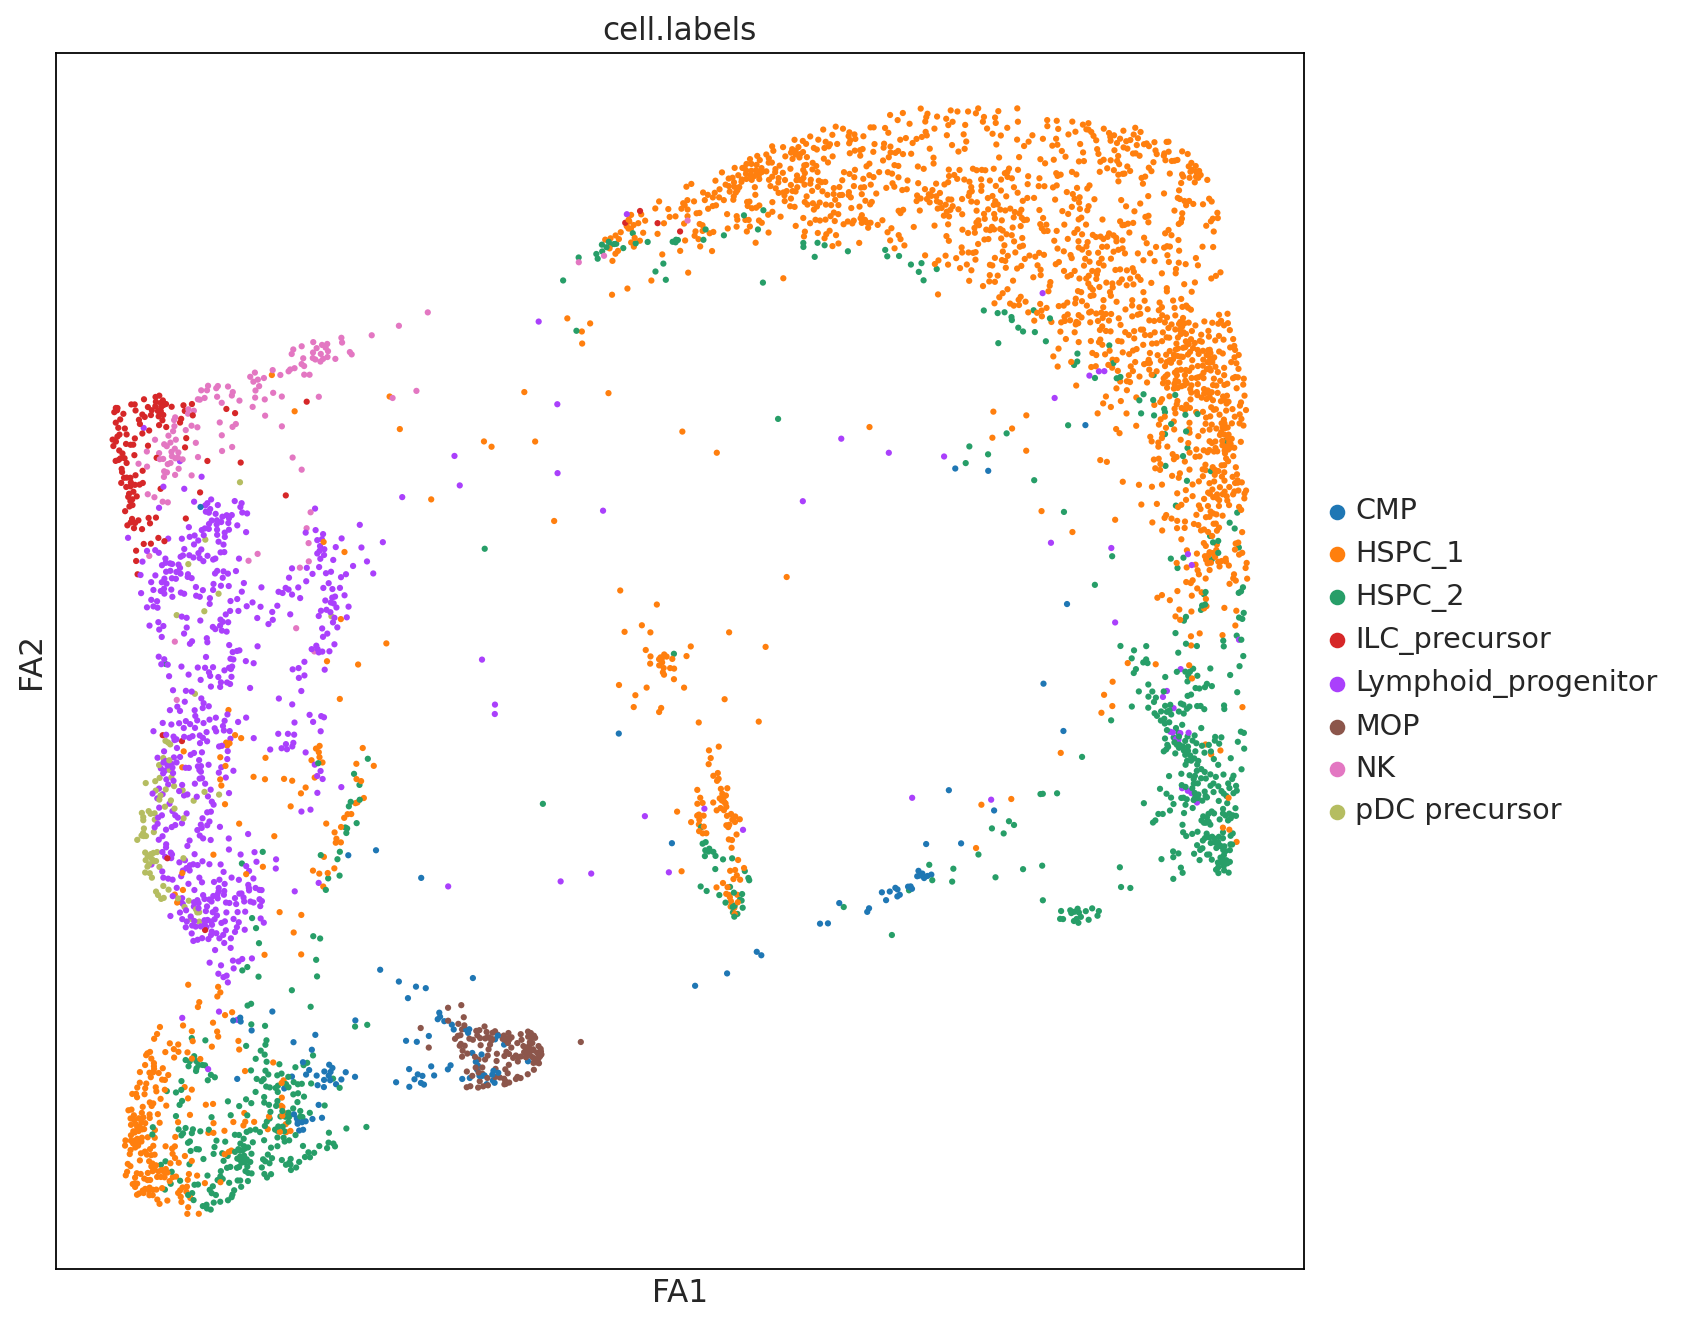

In [143]:
sc.pl.draw_graph(adata, color = 'cell.labels')

In [35]:
save_loc+run_name+'.h5ad'

'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/YS_lymphoid_progen_traj_030422.h5ad'

In [36]:
ys = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal_150921.csv")

In [37]:
## Vars
adata_var = "cell.labels"
col_pal = ys

In [38]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var]
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

7 {'LYMPHOID_PROGENITOR', 'MOP', 'CMP', 'HSPC_2', 'ILC_PRECURSOR', 'HSPC_1', 'NK'}
non_intersect {'PDC PRECURSOR', 'DC_PRECURSOR', 'HE', 'MEMP', 'MONOCYTE', 'LMPP', 'MK', 'VWF_EC', 'PROLIF_AEC', 'EO_BASO_MAST_PRECURSOR', 'PROMONOCYTE', 'AEC', 'ENDODERM', 'MESOTHELIUM', 'PROLIF_SINUSOIDAL_EC', 'EARLY_ERYTHROID', 'MONOCYTE_MACROPHAGE', 'PRE_MACROPHAGE', 'SMOOTH_MUSCLE', 'SINUSOIDAL_EC', 'MAST_CELL', 'FIBROBLAST', 'MACROPHAGE', 'MICROGLIA', 'NEUTROPHIL_PRECURSOR', 'IMMATURE_EC', 'ERYTHROID', 'EO_BASOPHIL', 'DC2'}


In [39]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

non_intersect {'PDC PRECURSOR', 'DC_PRECURSOR', 'HE', 'MEMP', 'MONOCYTE', 'LMPP', 'MK', 'VWF_EC', 'PROLIF_AEC', 'EO_BASO_MAST_PRECURSOR', 'PROMONOCYTE', 'AEC', 'ENDODERM', 'MESOTHELIUM', 'PROLIF_SINUSOIDAL_EC', 'EARLY_ERYTHROID', 'MONOCYTE_MACROPHAGE', 'PRE_MACROPHAGE', 'SMOOTH_MUSCLE', 'SINUSOIDAL_EC', 'MAST_CELL', 'FIBROBLAST', 'MACROPHAGE', 'MICROGLIA', 'NEUTROPHIL_PRECURSOR', 'IMMATURE_EC', 'ERYTHROID', 'EO_BASOPHIL', 'DC2'}


In [40]:
adata.obs['var']

Wang_et_al_AAACCTGCACTTAAGC_1                                       HSPC_1
Wang_et_al_AAAGATGGTTGGACCC_1                                       HSPC_1
Wang_et_al_AAAGTAGAGTGGTCCC_1                                       HSPC_1
Wang_et_al_AAATGCCTCTGACCTC_1                          LYMPHOID_PROGENITOR
Wang_et_al_AACACGTCATCTATGG_1                          LYMPHOID_PROGENITOR
                                                              ...         
F80_Yolksac_CD45N_FCAImmP8096694_GTCTTCGGTCGACTAT                      CMP
F80_Yolksac_CD45N_FCAImmP8096694_TGGCTGGAGCTAGGCA                   HSPC_2
F80_Yolksac_CD45N_FCAImmP8096695_AACACGTCAGACGCAA                      CMP
F80_Yolksac_CD45NAF_FCAImmP8096696_AACTTTCGTTCTCATT                    MOP
F80_Yolksac_CD45NAF_FCAImmP8096696_CCAGCGATCAACCAAC                    CMP
Name: var, Length: 3818, dtype: object

# Minor Corrections

In [55]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

non_intersect {'PROLIF_AEC', 'VWF_EC', 'AEC', 'SINUSOIDAL_EC', 'MESOTHELIUM', 'SMOOTH_MUSCLE', 'PROLIF_SINUSOIDAL_EC', 'ENDODERM', 'FIBROBLAST', 'IMMATURE_EC'}


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var' as categorical


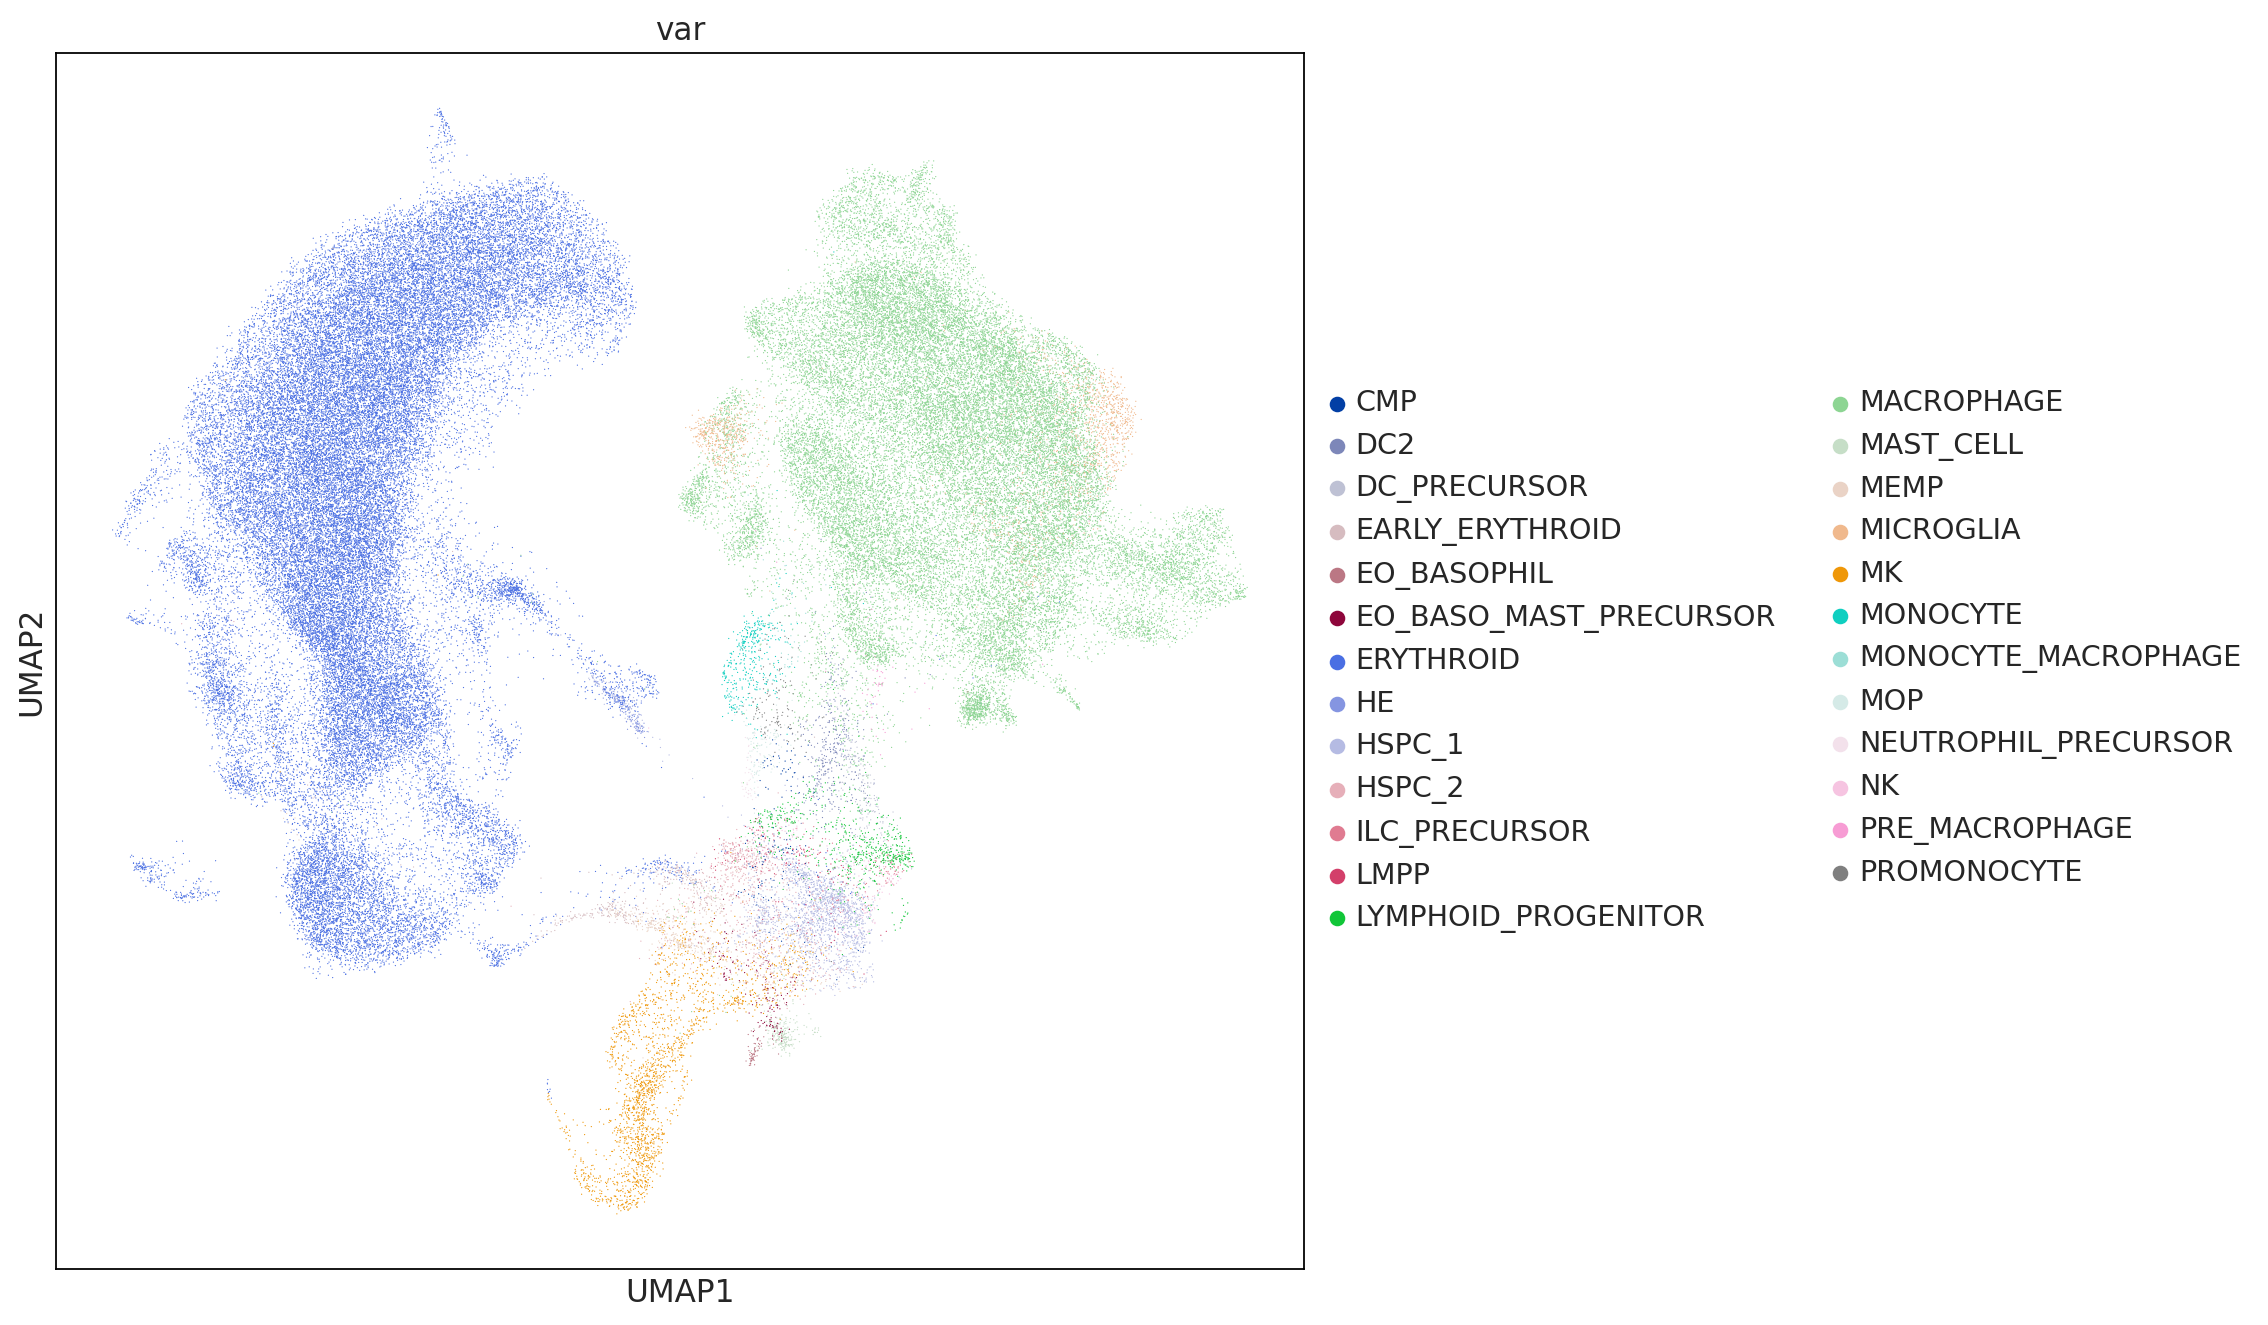

In [56]:
sc.pl.umap(adata, color = "var")

In [61]:
list(adata.obs['var']).sort()

# Create mappable field

In [63]:
pal

color
categories                     
CMP                     #67839C
DC2                     #6EA85B
DC_PRECURSOR            #A9E9B9
EARLY_ERYTHROID         #EA9BC2
EO_BASOPHIL             #634F81
EO_BASO_MAST_PRECURSOR  #814F75
ERYTHROID               #FFE8EC
HE                      #EB2A0A
HSPC_1                  #AFBFCC
HSPC_2                  #F0DB00
ILC_PRECURSOR           #F25602
LMPP                    #7A2839
LYMPHOID_PROGENITOR     #FFFF99
MACROPHAGE              #4C7BAB
MAST_CELL               #B0A789
MEMP                    #B87056
MICROGLIA               #1E38AD
MK                      #EE943F
MONOCYTE                #B49FC8
MONOCYTE_MACROPHAGE     #3E007C
MOP                     #AB0890
NEUTROPHIL_PRECURSOR    #05394A
NK                      #9B9B00
PRE_MACROPHAGE          #66B1D2
PROMONOCYTE             #E7D4E7

In [64]:
cells = list(adata.obs['var'].unique())
cells.sort()
col = list(range(0,len(cells)))
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

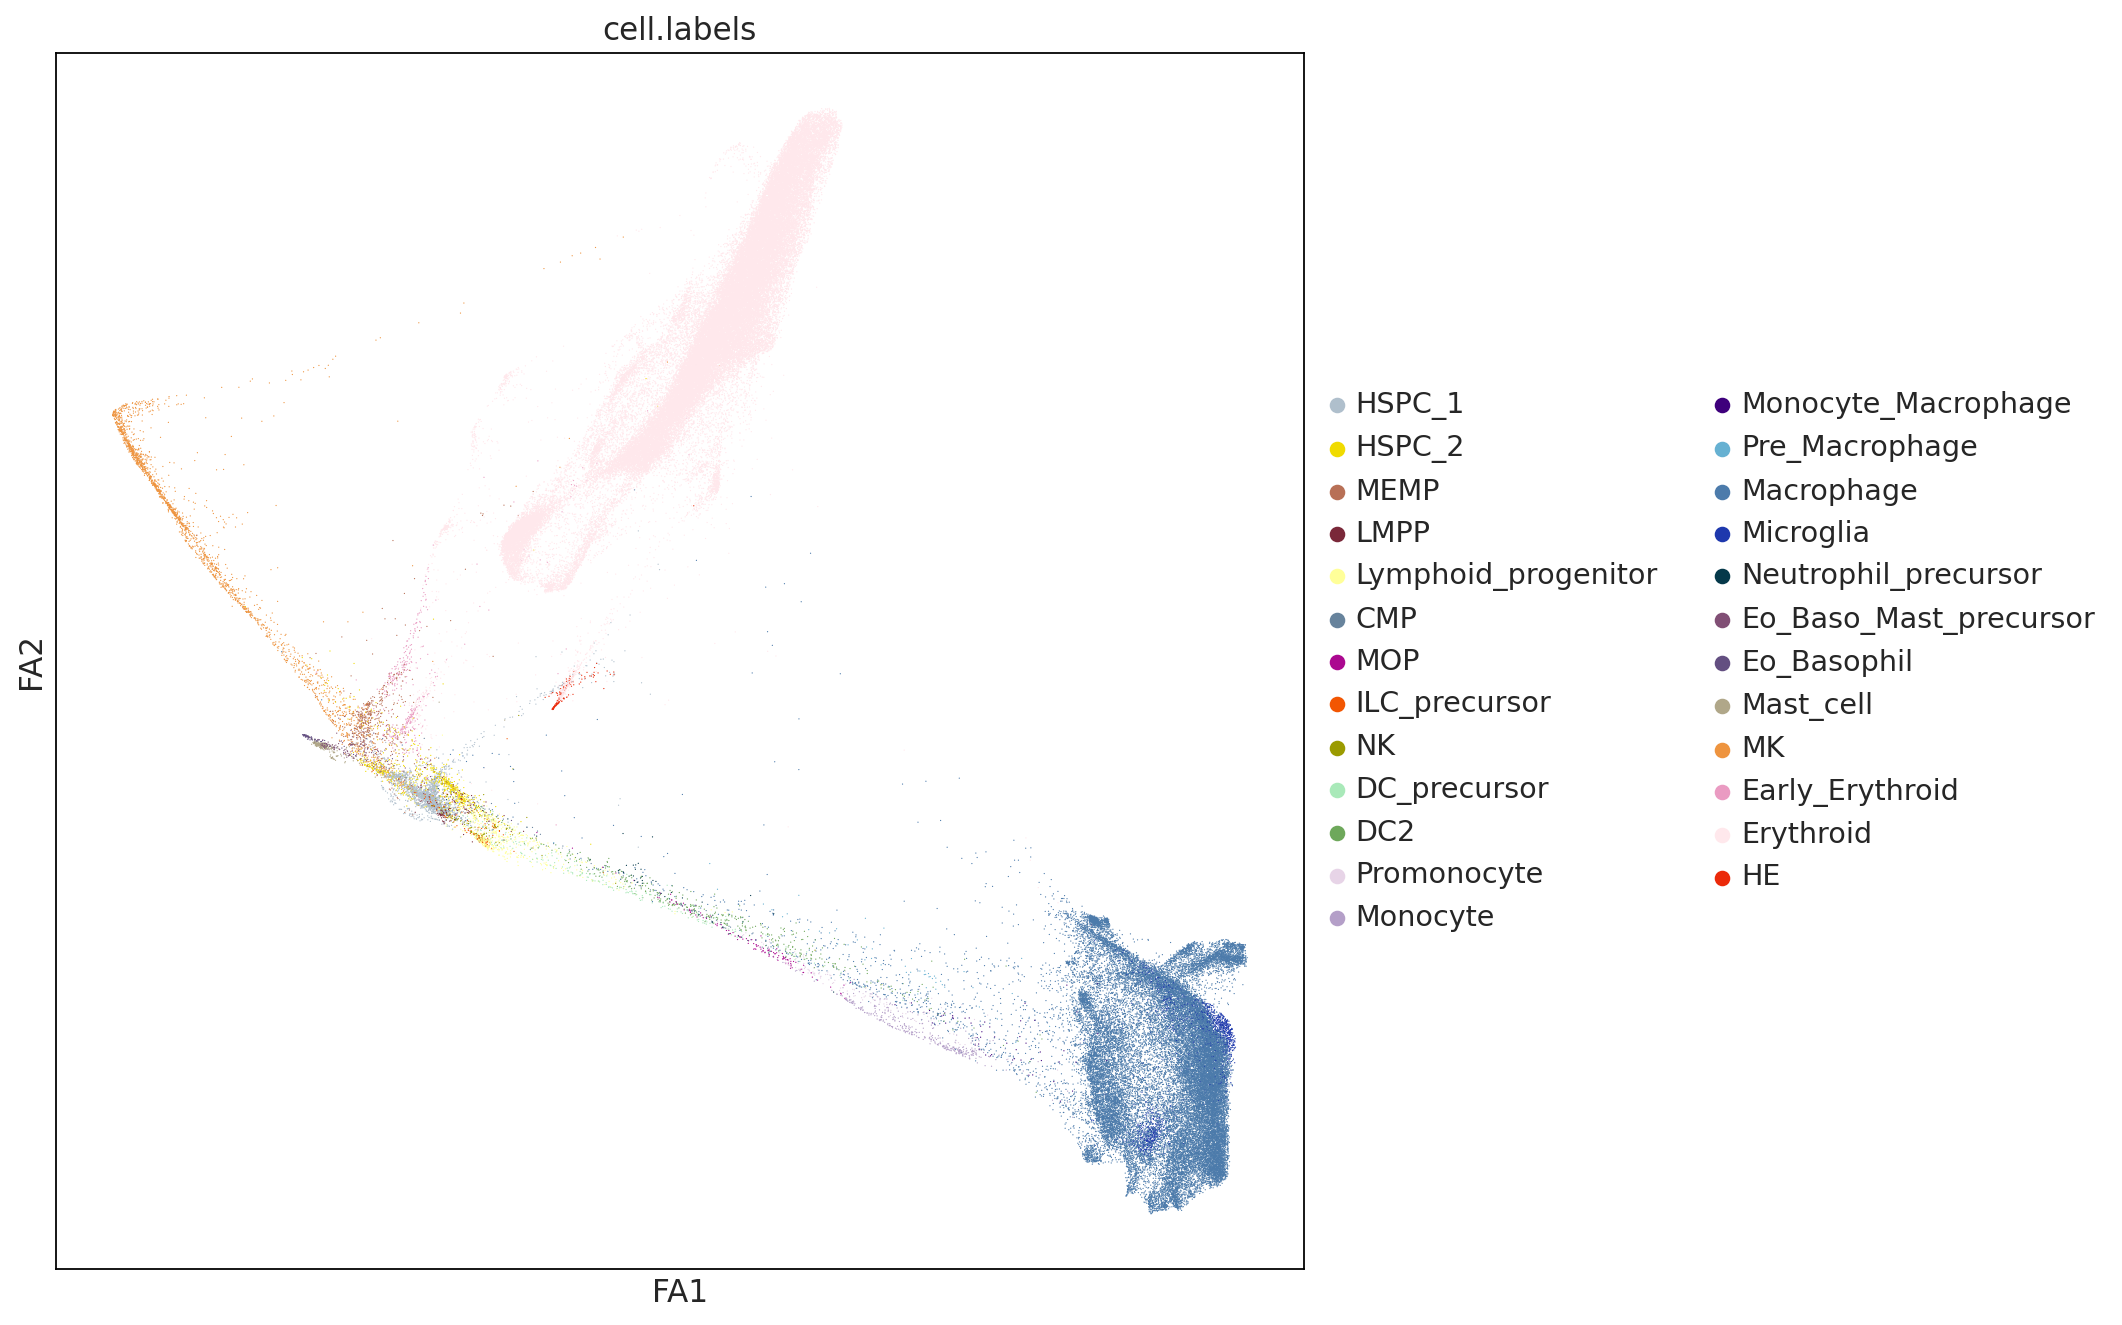

In [66]:
sc.pl.draw_graph(adata, color = 'cell.labels')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'num' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var_num' as categorical


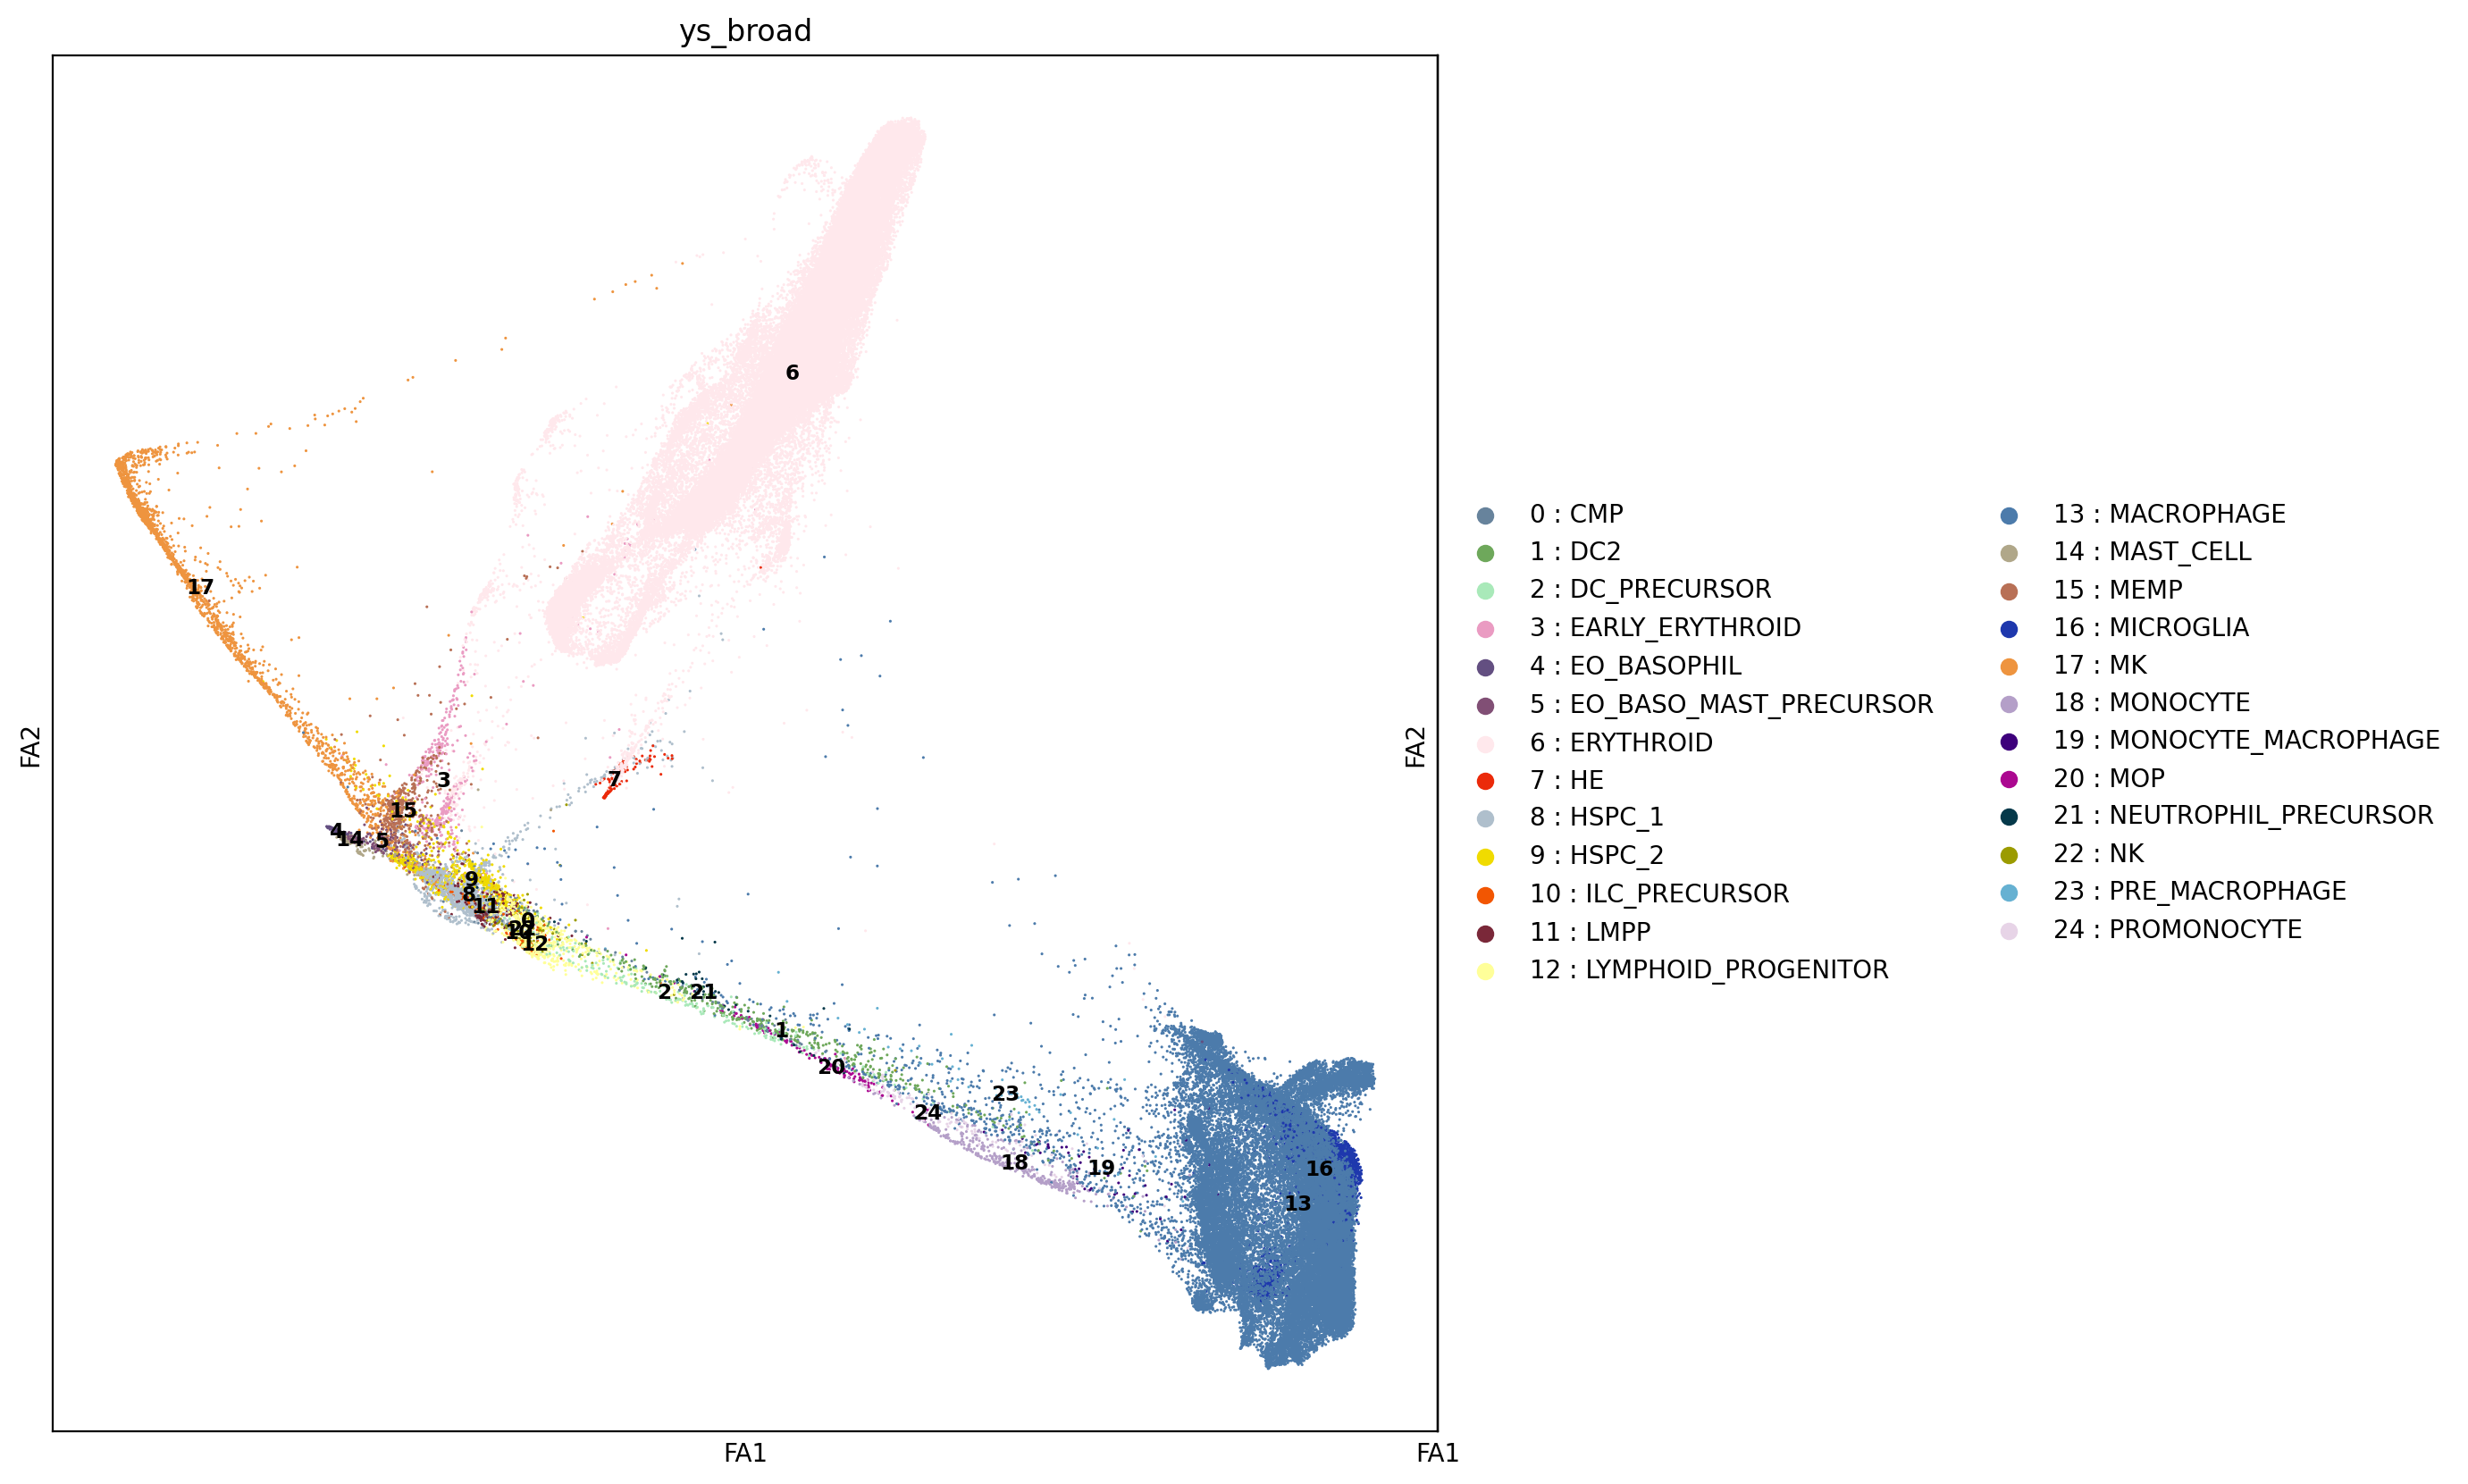

In [70]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.draw_graph(adata, color = (var+'_num') ,ax=ax2,show=False,size=5,title="", palette= col_pal) #title=i
p3 = sc.pl.draw_graph(adata, color = "num",legend_loc="on data",size=5,legend_fontsize='small',ax=ax1,show=False,title="ys_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"YS_total_TRAJ_num.pdf",bbox_inches='tight')

In [72]:
# Create a trajectory between AEC and HE to HSPC1,2
# Compare this to AGM, 

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'num' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var_num' as categorical


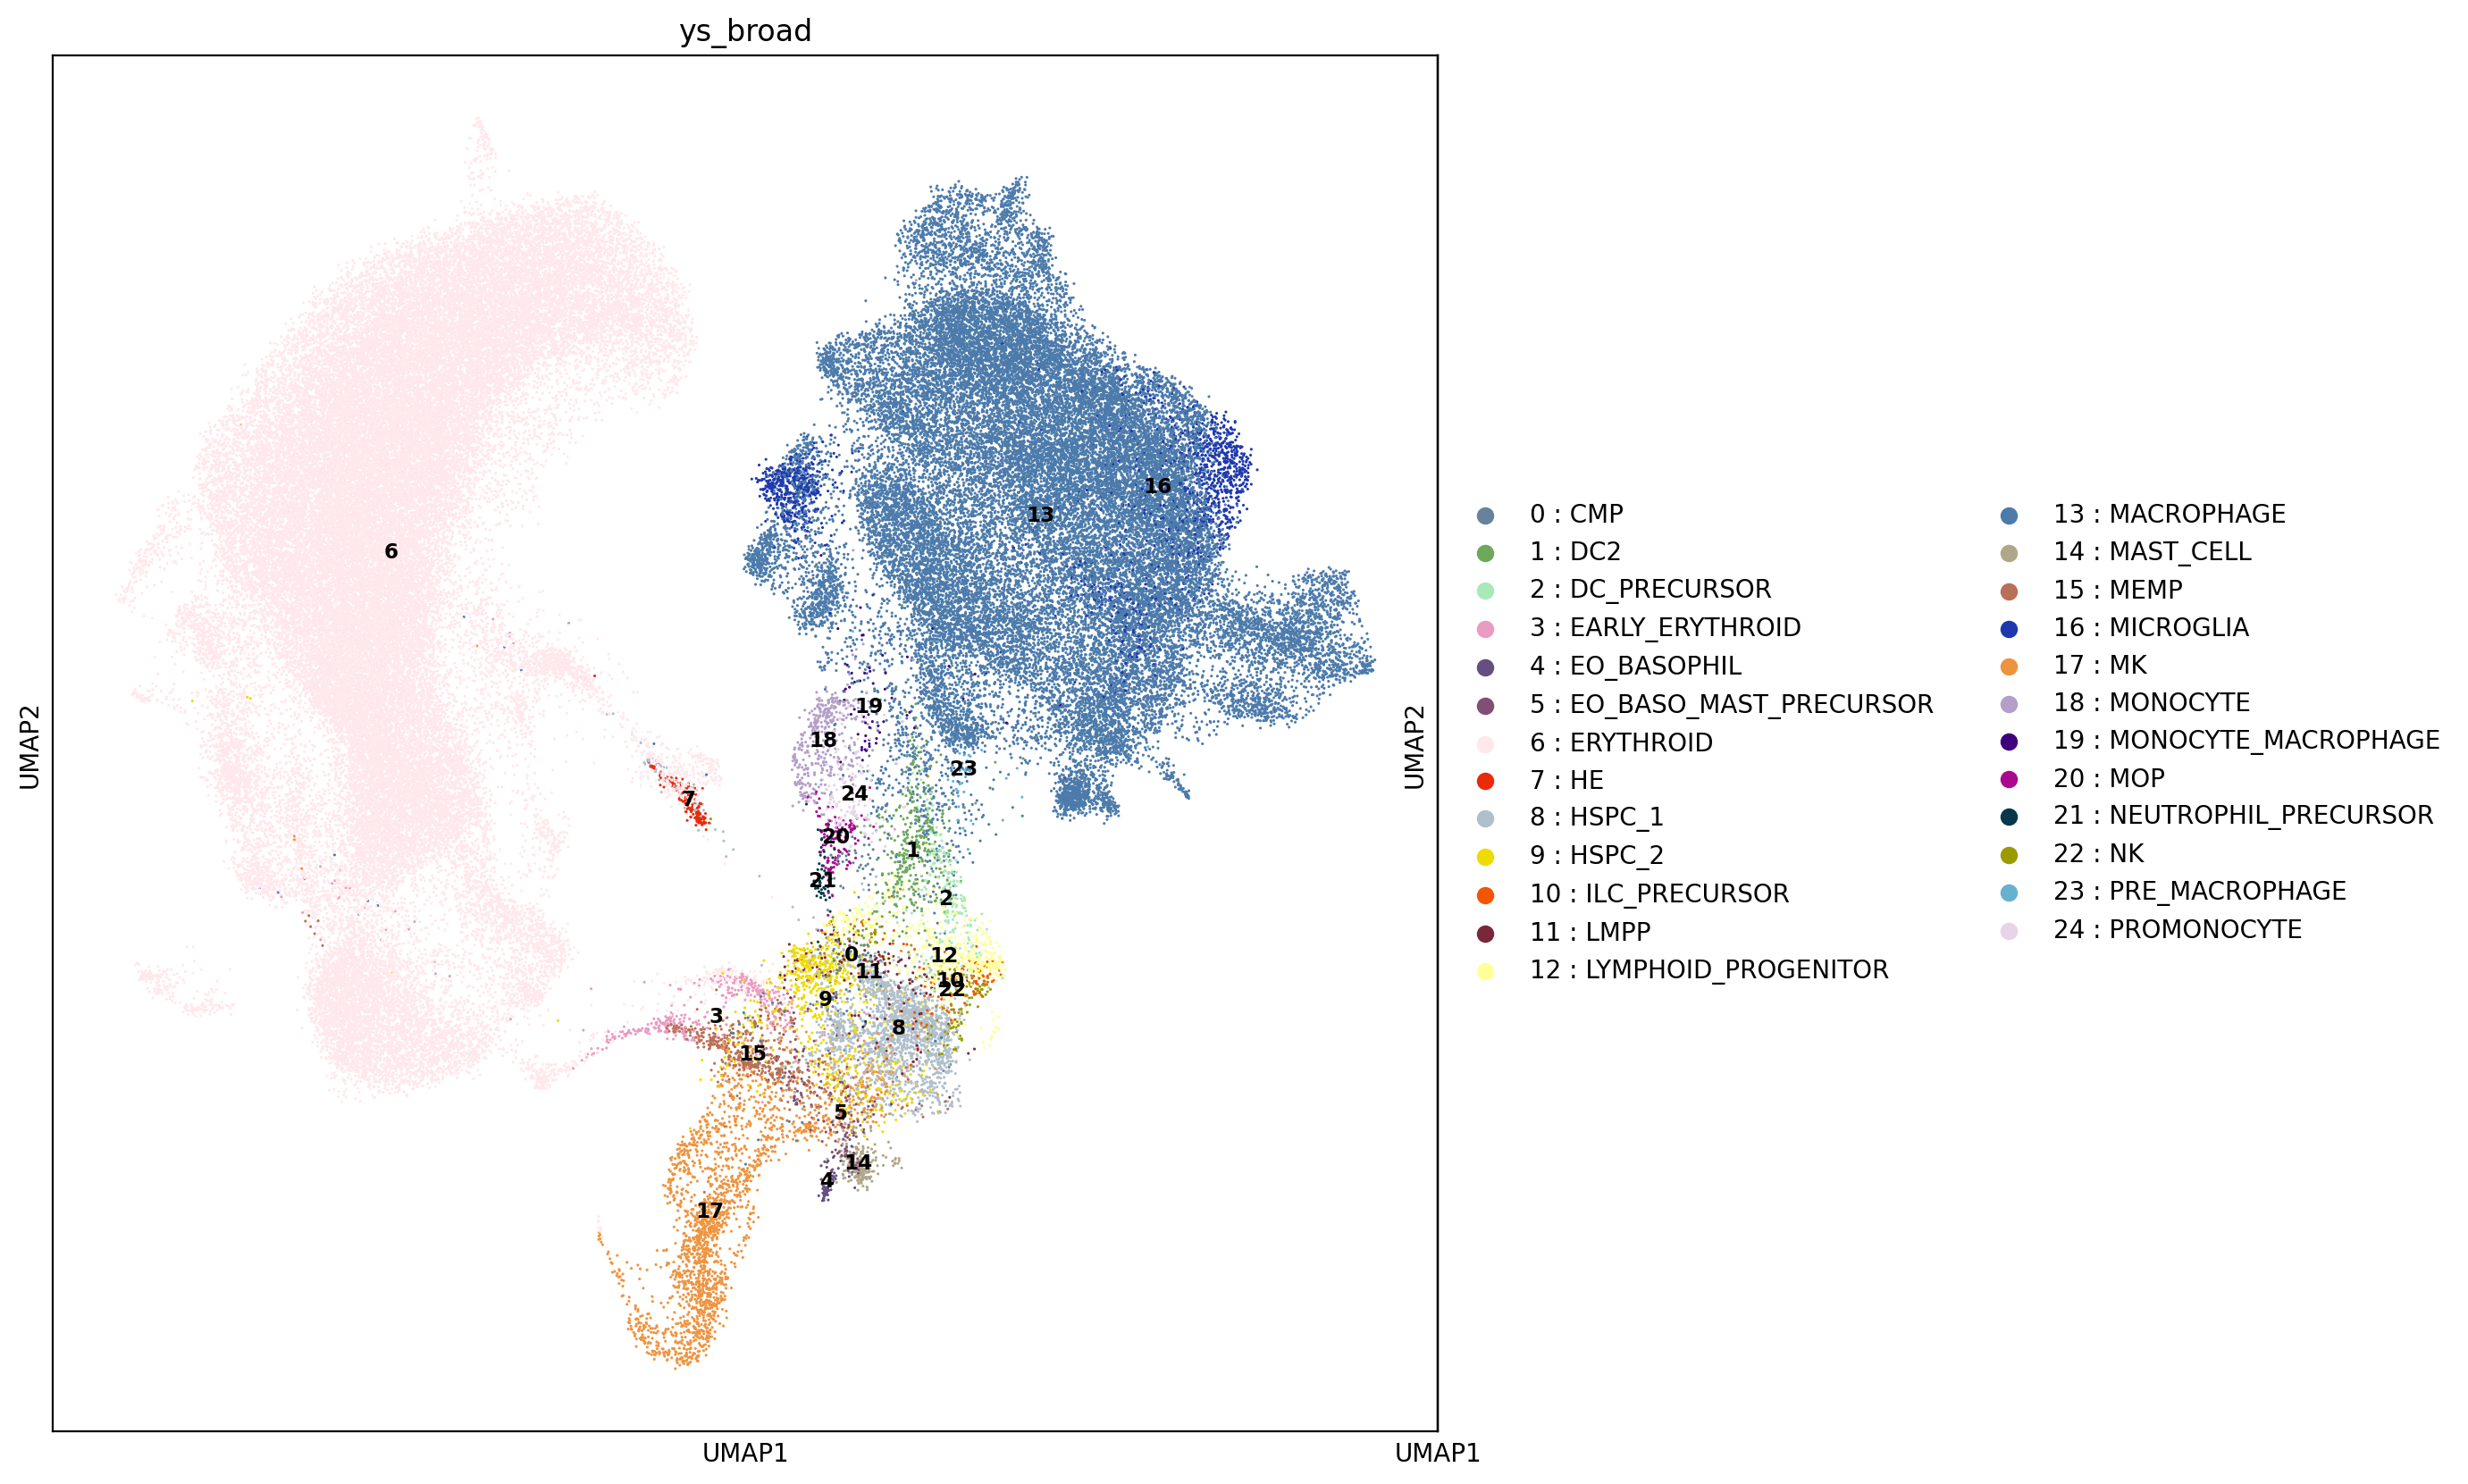

In [71]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,size=5,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=5,legend_fontsize='small',ax=ax1,show=False,title="ys_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"UMAP_YS_total_TRAJ_num.pdf_num.pdf",bbox_inches='tight')